In [2]:
import pandas as pd
import numpy as np
import datetime

import time
import matplotlib.pyplot as plt
from numba import jit


import seaborn as sns
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import os
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


#own functions -> utils_model.py
import utils_model as um

# Import Data

### Data off chain 
- source: tradingview

In [22]:
df_off = pd.read_csv('../model-2/data/off_chain.csv', sep=';', skiprows=1)

In [23]:
df_off['time'] = df_off['time'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%m-%d-%Y'))
df_off['time'] = pd.to_datetime(df_off['time'])
#df_off.set_index('time', inplace=True)


In [24]:
pd.concat([df_off.head(2), df_off.tail(2)])

time      open      high       low     close  Upper Bollinger   
0    2016-02-29    430.26    440.99    428.12    435.23       454.224439  \
1    2016-03-01    436.75    437.50    427.01    432.50       453.858323   
2624 2023-05-07  28909.00  29194.00  28444.00  28472.00     30194.609539   
2625 2023-05-08  28485.00  28667.00  27362.00  27459.00     29912.152054   

      Lower Bollinger  Upper Donchian  Lower Donchian       Volume  Red Arrow   
0          376.547561          447.99          372.12  8463.348832        0.0  \
1          382.197677          447.99          373.54  6942.062481        0.0   
2624     27129.390461        30483.00        26981.00  1021.457156        NaN   
2625     27118.247946        30423.00        26981.00  2172.922034        NaN   

      Green Arrow        RSI  Put-call Ratio  Detrended Price Oscillator  
0             0.0  63.517353        1.191000                   50.310000  
1             0.0  61.378172      876.000000                   45.612381  
2624          NaN  48.421518        0.971189                 -455.476190  
2625          NaN  41.889956        0.967976                -1536.761905

- source: ask roy

In [25]:
df_off2 = pd.read_csv('../model-2/data/off_chain_clean.csv')
df_off2.columns = ['time', 'ratio_mvrv', 'ratio_met', 'ratio_nvt', 'ratio_stf']
df_off2['time'] = pd.to_datetime(df_off2['time'])


In [26]:
pd.concat([df_off2.head(2), df_off2.tail(2)])

time  ratio_mvrv     ratio_met  ratio_nvt      ratio_stf
0    2016-02-03    1.225057  1.029619e+10  10.526262     408.535798
1    2016-02-04    1.289302  1.269649e+10   6.784755     408.717123
2652 2023-05-09    1.375212  7.041946e+10  59.907278  112726.323320
2653 2023-05-10    1.372930  5.950002e+10  54.432039  112627.506594

- source: ask Iñaki

In [27]:
df_off3 = pd.read_csv('../model-2/data/off_chain_monthly.csv')
df_off3['time'] = pd.to_datetime(df_off3['time'])

In [28]:
pd.concat([df_off3.head(2), df_off3.tail(2)])

time  Value_M3  Value_CPI  Value_EFF  Value_SP500  Value_USpce   
0    2016-01-01  0.009969  -0.811782       0.34        -5.07         0.82  \
1    2016-01-02  0.009969  -0.811782       0.34        -5.07         0.82   
2615 2023-02-28 -0.006440  -0.058428       4.57        -2.61         5.08   
2616 2023-03-01 -0.012208  -0.174073       4.65         3.51         4.16   

      Value_USreal  Variation_UStotal  Value_USunem  
0              NaN           0.083799           4.9  
1              NaN           0.083799           4.9  
2615           NaN           0.161020           3.6  
2616           1.1           0.102947           3.5

### Data on chain

- source: Iñaki

In [30]:
df_on = pd.read_csv('../model-2/data/on_chain_roy.csv', sep=';')

#change Date column to 'time' for future join
df_on['time'] = pd.to_datetime(df_on['Date'])
df_on.drop('Date', axis=1, inplace=True)

In [31]:
df_on['US_bank_idx'].fillna(method='ffill', inplace=True)
df_on['US_bank_idx'][0:3] = df_on['US_bank_idx'][3]

In [32]:
df_on.head(5)

hash_rate  active_addre  tran_sec  tran_num  block_size  rev_all_miners   
0  6.869991e+17        316489  1.434687    123957    66609963     3394.820806  \
1  7.466684e+17        419389  1.723299    148893    84062840     3656.376005   
2  7.432371e+17        394047  1.648877    142463    80425082     3649.083049   
3  9.249701e+17        418253  2.096910    181173   100811640     4555.746843   
4  8.062655e+17        434786  2.108958    182214   100759295     3957.278467   

   block_reward  size_tran  trans_fees  US_bank_idx       time  
0        3375.0   66570062   19.820806       320.48 2016-01-01  
1        3625.0   84021661   31.376005       320.48 2016-01-02  
2        3625.0   80388881   24.083049       320.48 2016-01-03  
3        4525.0  100770969   30.746843       320.48 2016-01-04  
4        3925.0  100702961   32.278467       320.47 2016-01-05

In [34]:
df_on2 = pd.read_csv('../model-2/data/on_chain_paper.csv')

#change Date column to 'time' for future join
df_on2['time'] = pd.to_datetime(df_on2['timestamp'])
df_on2.drop('timestamp', axis=1, inplace=True)

In [35]:
df_on2.head()

bitcoin-aggregate-security-spend-thermocap-usd  bitcoin-balanced-price-usd   
0                                    1.501750e+09                  232.941445  \
1                                    1.503310e+09                  233.108481   
2                                    1.505269e+09                  233.317436   
3                                    1.506969e+09                  233.463981   
4                                    1.508489e+09                  233.598780   

   bitcoin-block-height  bitcoin-circulating-supply-btc   
0              391461.0                      15036550.0  \
1              391606.0                      15040175.0   
2              391787.0                      15044700.0   
3              391944.0                      15048625.0   
4              392085.0                      15052150.0   

   bitcoin-cumulative-value-days-destroyed-cvdd  bitcoin-delta-cap-usd   
0                                    169.513770           2.130788e+09  \
1                                    169.551559           2.132321e+09   
2                                    169.582557           2.134635e+09   
3                                    169.652235           2.136111e+09   
4                                    169.693939           2.137175e+09   

   bitcoin-investor-capitalization  bitcoin-market-cap-usd   
0                     3.017969e+09            6.539733e+09  \
1                     3.019992e+09            6.482312e+09   
2                     3.022417e+09            6.527925e+09   
3                     3.024257e+09            6.518562e+09   
4                     3.025839e+09            6.471301e+09   

   bitcoin-market-value-to-realized-value-ratio-mvrv   
0                                           1.446934  \
1                                           1.433093   
2                                           1.441780   
3                                           1.438587   
4                                           1.427180   

   bitcoin-median-value-of-created-utxos-btc  ...   
0                                   0.010013  ...  \
1                                   0.009600  ...   
2                                   0.023020  ...   
3                                   0.023085  ...   
4                                   0.035541  ...   

   bitcoin-number-of-utxos-in-profit   
0                         28121748.0  \
1                         27821500.0   
2                         28060343.0   
3                         27773959.0   
4                         27523321.0   

   bitcoin-percent-of-supply-last-active-3-years-ago   
0                                           0.234676  \
1                                           0.234755   
2                                           0.235872   
3                                           0.236059   
4                                           0.236092   

   bitcoin-price-drawdown-from-ath  bitcoin-realized-cap-usd   
0                        -0.625919              4.519718e+09  \
1                        -0.629293              4.523302e+09   
2                        -0.626796              4.527686e+09   
3                        -0.627429              4.531225e+09   
4                        -0.630217              4.534328e+09   

   bitcoin-realized-price-usd  bitcoin-relative-unrealized-profit   
0                  300.582136                            0.419200  \
1                  300.747943                            0.416286   
2                  300.948917                            0.417304   
3                  301.105603                            0.415948   
4                  301.241185                            0.414372   

   bitcoin-stock-to-flow-ratio-usd   
0                       407.818293  \
1                       408.602172   
2                       408.816902   
3                       409.175572   
4                       409.952007   

   bitcoin-total-supply-last-active-3y-5y-btc   
0                              

### Join four dfs

In [36]:
join1 = df_off.merge(df_off2, on='time', how='left')
join2 = join1.merge(df_off3, on='time', how='left')

join_on_off = join2.merge(df_on, on='time', how='left')
join_on_off2 = join_on_off.merge(df_on2, on='time', how='left')

In [38]:
pd.concat([join_on_off2.head(2), join_on_off.tail(2)])

time      open      high       low     close  Upper Bollinger   
0    2016-02-29    430.26    440.99    428.12    435.23       454.224439  \
1    2016-03-01    436.75    437.50    427.01    432.50       453.858323   
2624 2023-05-07  28909.00  29194.00  28444.00  28472.00     30194.609539   
2625 2023-05-08  28485.00  28667.00  27362.00  27459.00     29912.152054   

      Lower Bollinger  Upper Donchian  Lower Donchian       Volume  ...   
0          376.547561          447.99          372.12  8463.348832  ...  \
1          382.197677          447.99          373.54  6942.062481  ...   
2624     27129.390461        30483.00        26981.00  1021.457156  ...   
2625     27118.247946        30423.00        26981.00  2172.922034  ...   

      bitcoin-number-of-addresses  bitcoin-number-of-utxos-in-profit   
0                     130439086.0                         30149193.0  \
1                     130726654.0                         29483703.0   
2624                          NaN                                NaN   
2625                          NaN                                NaN   

      bitcoin-percent-of-supply-last-active-3-years-ago   
0                                              0.241849  \
1                                              0.241793   
2624                                                NaN   
2625                                                NaN   

      bitcoin-price-drawdown-from-ath  bitcoin-realized-cap-usd   
0                           -0.624629              4.669757e+09  \
1                           -0.627376              4.680476e+09   
2624                              NaN                       NaN   
2625                              NaN                       NaN   

      bitcoin-realized-price-usd  bitcoin-relative-unrealized-profit   
0                     305.912172                            0.399139  \
1                     306.543607                            0.394330   
2624                         NaN                                 NaN   
2625                         NaN                                 NaN   

      bitcoin-stock-to-flow-ratio-usd   
0                          415.472196  \
1                          416.250575   
2624                              NaN   
2625                              NaN   

      bitcoin-total-supply-last-active-3y-5y-btc   
0                                   1.513814e+06  \
1                                   1.512680e+06   
2624                                         NaN   
2625                                         NaN   

      bitcoin-total-supply-last-active-5y-7y-btc  
0                                   1.925304e+06  
1                                   1.921633e+06  
2624                                         NaN  
2625                                         NaN  

[4 rows x 67 columns]

In [39]:
df = join_on_off2.copy()

In [40]:
len(df.columns)

67

# EDA

In [41]:
#rename columns name bc of large names

df.columns = ['time', 'open', 'high', 'low', 'close', 'Upper Bollinger',
       'Lower Bollinger', 'Upper Donchian', 'Lower Donchian', 'Volume',
       'Red Arrow', 'Green Arrow', 'RSI', 'Put-call Ratio',
       'Detrended Price Oscillator', 'ratio_mvrv', 'ratio_met', 'ratio_nvt',
       'ratio_stf', 'Value_M3', 'Value_CPI', 'Value_EFF', 'Value_SP500',
       'Value_USpce', 'Value_USreal', 'Variation_UStotal', 'Value_USunem',
       'hash_rate', 'active_addre', 'tran_sec', 'tran_num', 'block_size',
       'rev_all_miners', 'block_reward', 'size_tran', 'trans_fees',
       'US_bank_idx', 'thermocap-usd', 'price-usd',
       'block-height', 'supply-btc', 'destroyed-cvdd', 'delta-cap-usd',
       'capitalization', 'market-cap-usd', 'ratio-mvrv', 'created-utxos-btc',
       'spent-utxos-btc', 'mining-difficulty', 'z-score', 'balance-0-1',
       'balance-0-01', 'balance-1', 'balance-1k', 'balance-10', 'balance-10k',
       'balance-100', 'number-of-addresses', 'number-of-utxos',
       'percent-of-supply', 'price-drawdown', 'cap-usd', 'realized-price-usd',
       'unrealized-profit', 'stock-to-flow', 'active-3y-5y-btc',
       'active-5y-7y-btc']

In [42]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'Upper Bollinger',
       'Lower Bollinger', 'Upper Donchian', 'Lower Donchian', 'Volume',
       'Red Arrow', 'Green Arrow', 'RSI', 'Put-call Ratio',
       'Detrended Price Oscillator', 'ratio_mvrv', 'ratio_met', 'ratio_nvt',
       'ratio_stf', 'Value_M3', 'Value_CPI', 'Value_EFF', 'Value_SP500',
       'Value_USpce', 'Value_USreal', 'Variation_UStotal', 'Value_USunem',
       'hash_rate', 'active_addre', 'tran_sec', 'tran_num', 'block_size',
       'rev_all_miners', 'block_reward', 'size_tran', 'trans_fees',
       'US_bank_idx', 'thermocap-usd', 'price-usd', 'block-height',
       'supply-btc', 'destroyed-cvdd', 'delta-cap-usd', 'capitalization',
       'market-cap-usd', 'ratio-mvrv', 'created-utxos-btc', 'spent-utxos-btc',
       'mining-difficulty', 'z-score', 'balance-0-1', 'balance-0-01',
       'balance-1', 'balance-1k', 'balance-10', 'balance-10k', 'balance-100',
       'number-of-addresses', 'number-of-utxos', 'percent-of-suppl

In [43]:
df.describe()

time          open          high           low   
count                 2626   2626.000000   2626.000000   2626.000000  \
mean   2019-10-03 12:00:00  15941.385072  16378.521565  15446.306257   
min    2016-02-29 00:00:00    399.770000    408.980000    377.870000   
25%    2017-12-16 06:00:00   3995.937500   4112.787500   3900.000000   
50%    2019-10-03 12:00:00   9209.645000   9386.815000   8989.505000   
75%    2021-07-20 18:00:00  22739.552500  23268.692500  22269.922500   
max    2023-05-08 00:00:00  67547.490000  69000.000000  66250.000000   
std                    NaN  16376.152221  16820.960965  15852.661245   

              close  Upper Bollinger  Lower Bollinger  Upper Donchian   
count   2626.000000      2626.000000      2626.000000     2626.000000  \
mean   15951.797361     17869.380983     13829.953985    17995.962947   
min      399.830000       420.353195       376.547561      421.910000   
25%     3999.130000      4548.535928      3465.793889     4480.000000   
50%     9210.995000     10114.615744      7856.785584    10235.375000   
75%    22755.252500     24764.037297     19029.715277    24921.000000   
max    67559.000000     68891.603000     59033.265427    69000.000000   
std    16375.270093     18373.669834     14372.607514    18451.084207   

       Lower Donchian        Volume  ...  number-of-addresses   
count     2626.000000   2626.000000  ...         2.626000e+03  \
mean     13572.347666   7268.753707  ...         5.923087e+08   
min        372.120000     21.380492  ...         1.304391e+08   
25%       3476.000000   2610.695704  ...         3.459546e+08   
50%       7733.990000   5255.522660  ...         5.641560e+08   
75%      19526.000000   9583.654055  ...         8.550868e+08   
max      58400.000000  70961.369658  ...         1.128130e+09   
std      13995.409719   6745.237195  ...         2.944434e+08   

       number-of-utxos  percent-of-supply  price-drawdown       cap-usd   
count     2.626000e+03        2626.000000     2626.000000  2.626000e+03  \
mean      7.377975e+07           0.321008       -0.452716  1.728428e+11   
min       2.665984e+07           0.241393       -0.836611  4.669757e+09   
25%       4.416131e+07           0.275618       -0.641868  7.357318e+10   
50%       6.935587e+07           0.313273       -0.495134  1.013888e+11   
75%       1.055591e+08           0.360177       -0.273126  3.734620e+11   
max       1.254309e+08           0.399817        0.000000  4.682810e+11   
std       3.093547e+07           0.044710        0.231884  1.616887e+11   

       realized-price-usd  unrealized-profit  stock-to-flow  active-3y-5y-btc   
count         2626.000000        2626.000000    2626.000000      2.626000e+03  \
mean          9272.554024           0.489440   37618.554973      2.032345e+06   
min            305.912172           0.305923     415.472196      8.321829e+05   
25%           4342.494719           0.410273    5606.010349      1.549044e+06   
50%           5586.092759           0.469335    8201.975431      2.105369e+06   
75%          19751.816084           0.561407  104091.971419      2.522327e+06   
max          24622.541332           0.793415  112678.453545      3.213435e+06   
std           8412.340040           0.106032   45614.030235      6.515442e+05   

       active-5y-7y-btc  
count      2.626000e+03  
mean       1.123581e+06  
min        5.541065e+05  
25%        8.285448e+05  
50%        1.097031e+06  
75%        1.298122e+06  
max        1.925304e+06  
std        3.589327e+05  

[8 rows x 67 columns]

In [44]:
date_feat = 'time'
numerical_feat = df.drop(['time','Red Arrow', 'Green Arrow'], axis=1).columns
categorical_feat = ['Red Arrow', 'Green Arrow']

target = 'vol_future'

### Missing values

In [45]:
# Check if there are rows with high missing ratio we should consider as observations to remove
nan = df.apply(lambda df: df.isnull().sum()/len(df), axis=1)

In [46]:
max(nan)

0.14925373134328357

<Axes: ylabel='Count'>

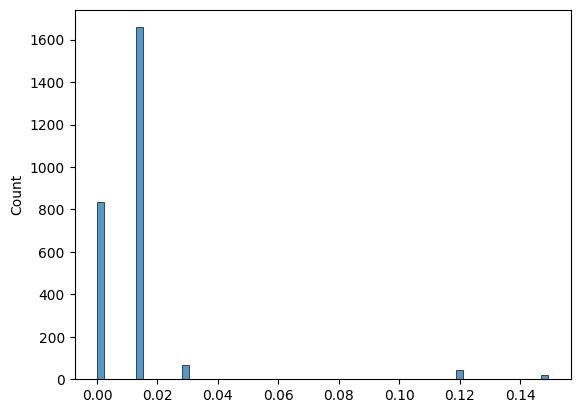

In [47]:
sns.histplot(df.apply(lambda df: df.isnull().sum()/len(df), axis=1))

Maximo ratio per row is 0.15, OK!

In [48]:
print(df[df['Red Arrow']==0].count()[0])
print(df[df['Red Arrow']==1].count()[0])

print(df[df['Green Arrow']==0].count()[0])
print(df[df['Green Arrow']==1].count()[0])

2567
39
2567
39


In [49]:
#deleting the two category columns because they are too unbalanced
df_nonan = df.drop(['Red Arrow', 'Green Arrow'], axis=1)

In [50]:
df_nonan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 65 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time                        2626 non-null   datetime64[ns]
 1   open                        2626 non-null   float64       
 2   high                        2626 non-null   float64       
 3   low                         2626 non-null   float64       
 4   close                       2626 non-null   float64       
 5   Upper Bollinger             2626 non-null   float64       
 6   Lower Bollinger             2626 non-null   float64       
 7   Upper Donchian              2626 non-null   float64       
 8   Lower Donchian              2626 non-null   float64       
 9   Volume                      2626 non-null   float64       
 10  RSI                         2626 non-null   float64       
 11  Put-call Ratio              2626 non-null   float64     

(array([1482.,  806.,  133.,   65.,   17.,    5.,   17.,    7.,    2.,
           5.]),
 array([1.68214509e+05, 1.48240190e+10, 2.96478697e+10, 4.44717205e+10,
        5.92955712e+10, 7.41194220e+10, 8.89432727e+10, 1.03767123e+11,
        1.18590974e+11, 1.33414825e+11, 1.48238676e+11]),
 <BarContainer object of 10 artists>)

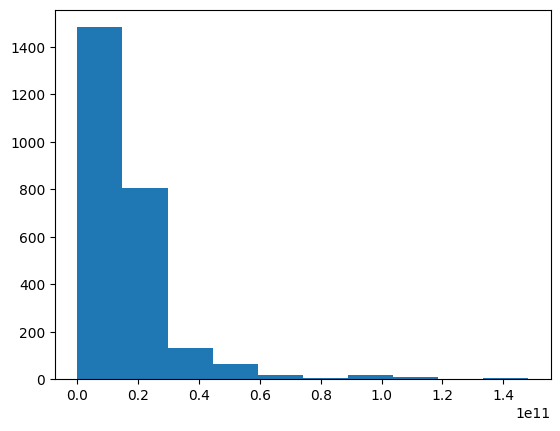

In [51]:
plt.hist(df['ratio_met'])

In [52]:
df['ratio_met'].describe()

count    2.539000e+03
mean     1.521253e+10
std      1.621965e+10
min      1.682145e+05
25%      4.626014e+09
50%      1.107878e+10
75%      2.022772e+10
max      1.482387e+11
Name: ratio_met, dtype: float64

In [53]:
df_nonan.drop('ratio_met', axis=1, inplace=True)

In [54]:
# columns: Value_M3, _CPI, _EFF, _SP500, _USpce 
# nans from 2023-03-02 to 2023-04-26 -> drop all rows --> new final date 2023-03-01

df_nonan = df_nonan.iloc[:2558]

In [55]:
# column: Value_USreal --> too many nans, drop column, ask Roy

df_nonan.drop('Value_USreal', axis=1, inplace=True)

In [56]:
df_nonan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 63 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time                        2558 non-null   datetime64[ns]
 1   open                        2558 non-null   float64       
 2   high                        2558 non-null   float64       
 3   low                         2558 non-null   float64       
 4   close                       2558 non-null   float64       
 5   Upper Bollinger             2558 non-null   float64       
 6   Lower Bollinger             2558 non-null   float64       
 7   Upper Donchian              2558 non-null   float64       
 8   Lower Donchian              2558 non-null   float64       
 9   Volume                      2558 non-null   float64       
 10  RSI                         2558 non-null   float64       
 11  Put-call Ratio              2558 non-null   float64     

In [58]:
df_nonan.to_csv('../model-2/data/df_nonan.csv', index=False)

# Feature Engineering

In [60]:
df_nonan = pd.read_csv('../model-2/data/df_nonan.csv')
df_nonan['time'] = pd.to_datetime(df_nonan['time'])
df_nonan.set_index('time', inplace=True)

# Date features
# df_nonan['time'] = pd.to_datetime(df_nonan['time'])
# df_nonan["fe_month"] = df_nonan['time'].dt.month
# df_nonan["fe_weekofyear"] = df_nonan['time'].dt.isocalendar().week.astype(int)
# df_nonan["fe_quarter"] = df_nonan['time'].dt.quarter
# df_nonan["fe_is_month_start"] = df_nonan['time'].dt.is_month_start.astype(int)
# df_nonan["fe_is_month_end"] = df_nonan['time'].dt.is_month_end.astype(int)

# new feat from price
df_nonan['log_price'] = np.log(df_nonan['close'].astype(float))
df_nonan['returns'] = df_nonan['close'].astype(float).pct_change().dropna() *100
df_nonan['log_return'] = df_nonan['log_price'] - df_nonan['log_price'].shift(1)

df_nonan['HL_sprd'] = np.log((df_nonan.high - df_nonan.low) / df_nonan.close)
df_nonan['CO_sprd'] = (df_nonan.close - df_nonan.open) / df_nonan.open
df_nonan['Volume'] = np.log(df_nonan.Volume) 

#df_nonan['Bollinger'] = np.log((df_nonan['Upper Bollinger'] - df_nonan['Lower Bollinger']) / df_nonan.close)
#df_nonan['Donchian'] = (df_nonan['Upper Donchian'] - df_nonan['Lower Donchian']) / df_nonan.close

In [61]:
#intervalos anchoring_idx
# A = 60k +- 60*0.04
# B = 50k +- 50*0.04
# C = 40k +- 40*0.04
# D = 30k +- 30*0.04
# E = 20k +- 20*0.04
# F = 10k +- 10*0.04


In [62]:
# df_nonan['Anchoring_idx_A'] = df_nonan['close'].apply(lambda x: 1 if x<(60000+(60000*0.04)) and x>(60000-(60000*0.04)) else 0)
# df_nonan['Anchoring_idx_B'] = df_nonan['close'].apply(lambda x: 1 if x<(50000+(50000*0.04)) and x>(50000-(50000*0.04)) else 0)
# df_nonan['Anchoring_idx_C'] = df_nonan['close'].apply(lambda x: 1 if x<(40000+(40000*0.04)) and x>(40000-(40000*0.04)) else 0)
# df_nonan['Anchoring_idx_D'] = df_nonan['close'].apply(lambda x: 1 if x<(30000+(30000*0.04)) and x>(30000-(30000*0.04)) else 0)
# df_nonan['Anchoring_idx_E'] = df_nonan['close'].apply(lambda x: 1 if x<(20000+(20000*0.04)) and x>(20000-(20000*0.04)) else 0)
# df_nonan['Anchoring_idx_F'] = df_nonan['close'].apply(lambda x: 1 if x<(10000+(10000*0.04)) and x>(10000-(10000*0.04)) else 0)

In [63]:
# DROPPING THE 1ST ROW OF DATA 
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df_nonan.drop(['open', 'high', 'low', 'close', 'Lower Bollinger',
       'Upper Donchian', 'Lower Donchian'], axis=1, inplace=True)


### Volatility

In [64]:
intervals = [7, 30, 60, 180, 365]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df_nonan.log_return.rolling(window=i)\
                         .apply(um.realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df_nonan.index)

Let's try first 30 days

In [65]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df_nonan['vol_current'] = df_nonan.log_return.rolling(window=INTERVAL_WINDOW)\
                                   .apply(um.realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df_nonan['vol_future'] = df_nonan.log_return.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(um.realized_volatility_daily)

In [66]:
df_nonan.describe()

Upper Bollinger       Volume          RSI  Put-call Ratio   
count      2558.000000  2558.000000  2558.000000     2558.000000  \
mean      17571.693473     8.541799    53.586380      430.512705   
std       18520.462393     0.898575    14.226812      432.576122   
min         420.353195     3.062479     9.632983        0.610000   
25%        4331.154580     7.903170    43.692198        1.027000   
50%        9986.003155     8.602975    52.632883      614.000000   
75%       23673.014855     9.185866    62.850820      862.000000   
max       68891.603000    11.169891    94.020499      999.000000   

       Detrended Price Oscillator   ratio_mvrv    ratio_nvt      ratio_stf   
count                 2558.000000  2558.000000  2558.000000    2558.000000  \
mean                   189.135046     1.816908    25.092327   35668.245018   
std                   3764.206269     0.701691    15.668259   44598.363200   
min                 -20204.532857     0.699270     0.795160     415.472196   
25%                   -766.345476     1.308447    11.902694    5597.454326   
50%                     42.142381     1.694712    23.353896    8181.002763   
75%                   1077.863810     2.177213    33.001133  100611.867473   
max                  21465.031905     4.850245    98.524587  111723.207855   

          Value_M3    Value_CPI  ...  stock-to-flow  active-3y-5y-btc   
count  2558.000000  2558.000000  ...    2558.000000      2.558000e+03  \
mean      0.589281    11.229368  ...   35668.245018      2.029045e+06   
std       2.361878    91.487119  ...   44598.363200      6.598211e+05   
min      -0.899724    -0.992588  ...     415.472196      8.321829e+05   
25%       0.001332    -0.092249  ...    5597.454326      1.520621e+06   
50%       0.004687     0.043663  ...    8181.002763      2.058563e+06   
75%       0.008650     0.203859  ...  100611.867473      2.538779e+06   
max       9.094759   836.626449  ...  111723.207855      3.213435e+06   

       active-5y-7y-btc    log_price      returns   log_return      HL_sprd   
count      2.558000e+03  2558.000000  2557.000000  2557.000000  2558.000000  \
mean       1.109915e+06     8.963447     0.234364     0.001562    -3.141547   
std        3.536150e+05     1.363249     3.931831     0.039653     0.717238   
min        5.541065e+05     5.991039   -38.980058    -0.493969    -6.337447   
25%        8.194549e+05     8.273629    -1.396104    -0.014059    -3.596472   
50%        1.088905e+06     9.105440     0.173139     0.001730    -3.113447   
75%        1.278960e+06     9.958158     1.869251     0.018520    -2.677850   
max        1.925304e+06    11.120757    26.921124     0.238396    -0.416202   

           CO_sprd  vol_current   vol_future  
count  2558.000000  2528.000000  2522.000000  
mean      0.002382     0.037116     0.037177  
std       0.039309     0.016265     0.016236  
min      -0.391466     0.006711     0.006711  
25%      -0.013876     0.027254     0.027331  
50%       0.001741     0.034791     0.034819  
75%       0.018920     0.045478     0.045502  
max       0.269043     0.110288     0.110288  

[8 rows x 62 columns]

In [67]:
# DROPPING ALL NaN VALUES
df_nonan.dropna(inplace=True)

# Multivariate Analysis

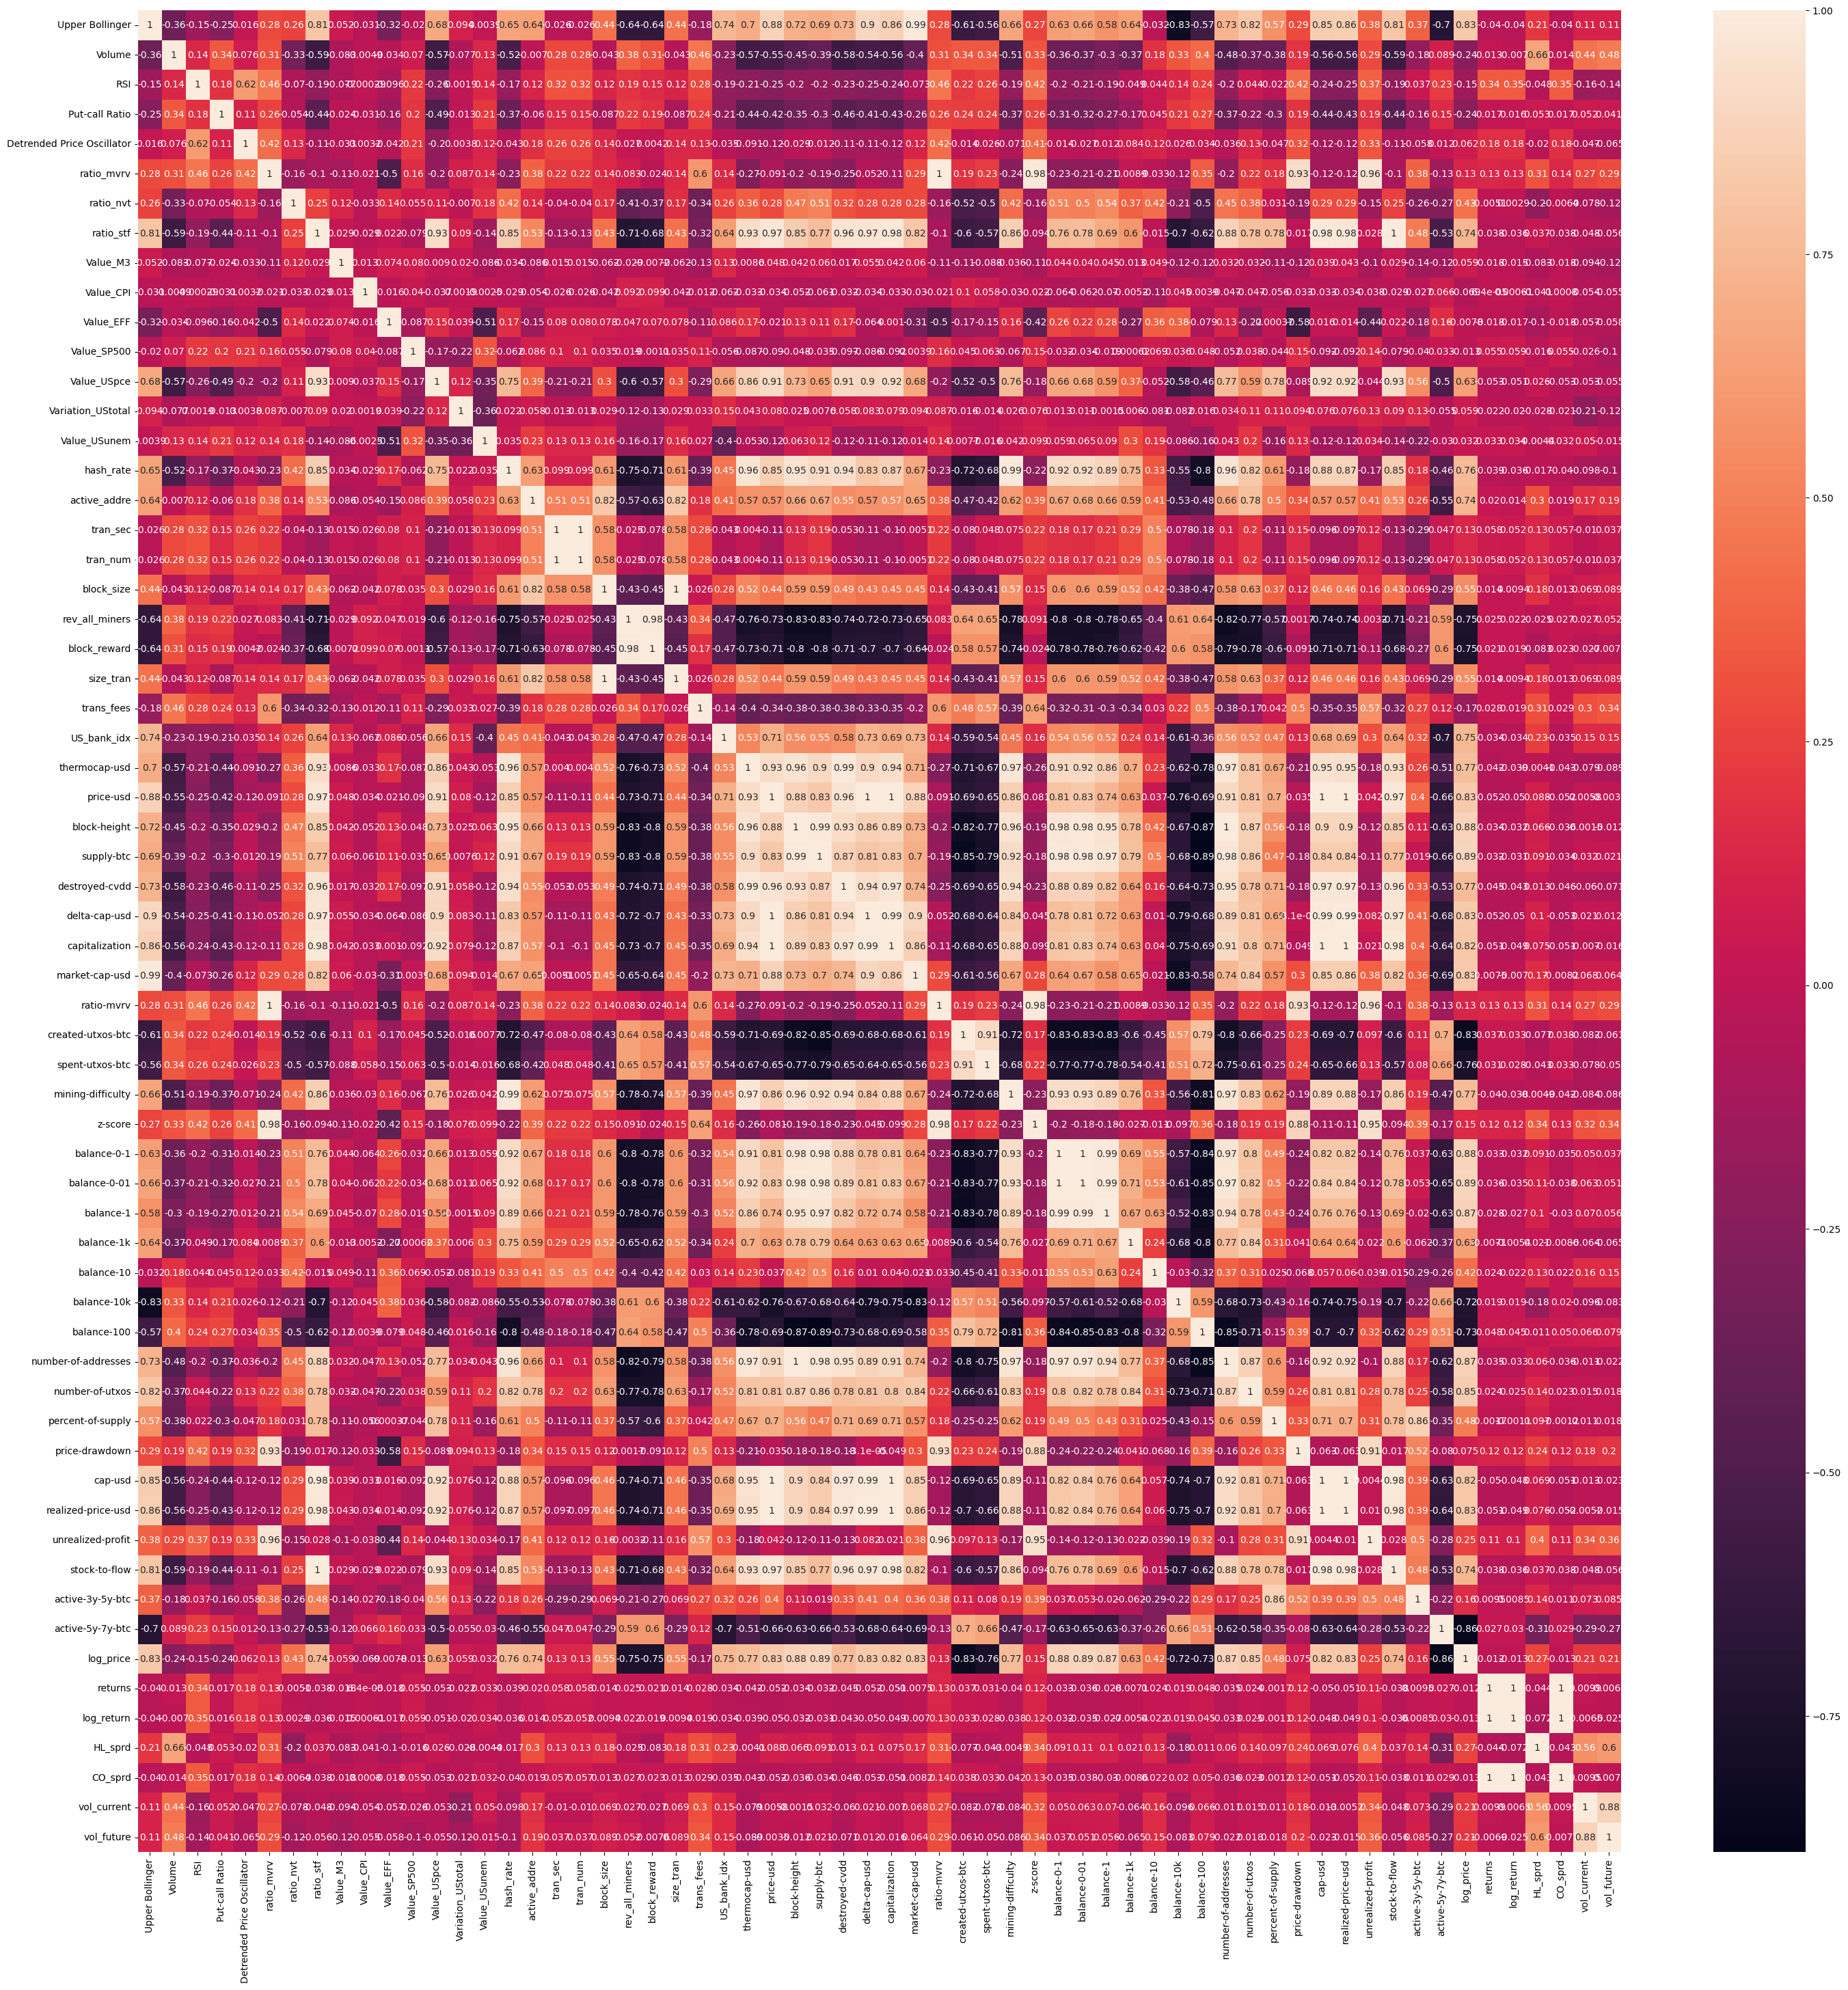

In [68]:
plt.figure(figsize=(35,35))
sns.heatmap(df_nonan.corr(), annot=True)
plt.show()

In [69]:
df_nonan.drop(['returns', 'log_price'], axis=1, inplace=True)

In [70]:
# Assuming df is your DataFrame

# Compute the correlation matrix
corr = df_nonan.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Apply the mask to get the lower triangle of the correlation matrix
corr_lower = corr.where(~mask)

# Find pairs of columns that have a correlation of 0.8 or higher, or -0.8 or lower
high_corr_pairs = [(c1, c2, corr_lower[c1][c2]) for c1 in corr_lower.columns for c2 in corr_lower.index if (abs(corr_lower[c1][c2]) > 0.8) and (c1 != c2)]

print("Highly correlated pairs with correlation values:")
for pair in high_corr_pairs:
    print(pair)

Highly correlated pairs with correlation values:
('Upper Bollinger', 'ratio_stf', 0.8131146139356215)
('Upper Bollinger', 'price-usd', 0.8779575125530458)
('Upper Bollinger', 'delta-cap-usd', 0.9023612589280446)
('Upper Bollinger', 'capitalization', 0.861622327840955)
('Upper Bollinger', 'market-cap-usd', 0.9888096555590051)
('Upper Bollinger', 'balance-10k', -0.8263282591813853)
('Upper Bollinger', 'number-of-utxos', 0.8174125789379253)
('Upper Bollinger', 'cap-usd', 0.8513380725519815)
('Upper Bollinger', 'realized-price-usd', 0.8570222979795947)
('Upper Bollinger', 'stock-to-flow', 0.8131146139356215)
('ratio_mvrv', 'ratio-mvrv', 1.0)
('ratio_mvrv', 'z-score', 0.9835850795277041)
('ratio_mvrv', 'price-drawdown', 0.9321632135589786)
('ratio_mvrv', 'unrealized-profit', 0.9613378901136431)
('ratio_stf', 'Value_USpce', 0.9269684144422478)
('ratio_stf', 'hash_rate', 0.8454318666814644)
('ratio_stf', 'thermocap-usd', 0.9301954462012899)
('ratio_stf', 'price-usd', 0.974109667284825)
('rati

In [71]:
df_nonan_corr = df_nonan.drop(['Upper Bollinger', 'ratio_stf', 'Value_USpce', 'hash_rate', 'active_addre', 'tran_sec',
               'size_tran', 'rev_all_miners', 'supply-btc', 'thermocap-usd', 'price-usd', 'block-height', 'destroyed-cvdd',
               'delta-cap-usd', 'capitalization', 'market-cap-usd', 'ratio-mvrv', 'created-utxos-btc', 'mining-difficulty', 
               'z-score', 'balance-0-1', 'balance-0-01', 'balance-1', 'number-of-addresses', 'balance-1k', 'number-of-utxos',
               'active-3y-5y-btc', 'price-drawdown', 'cap-usd','realized-price-usd'], axis=1)

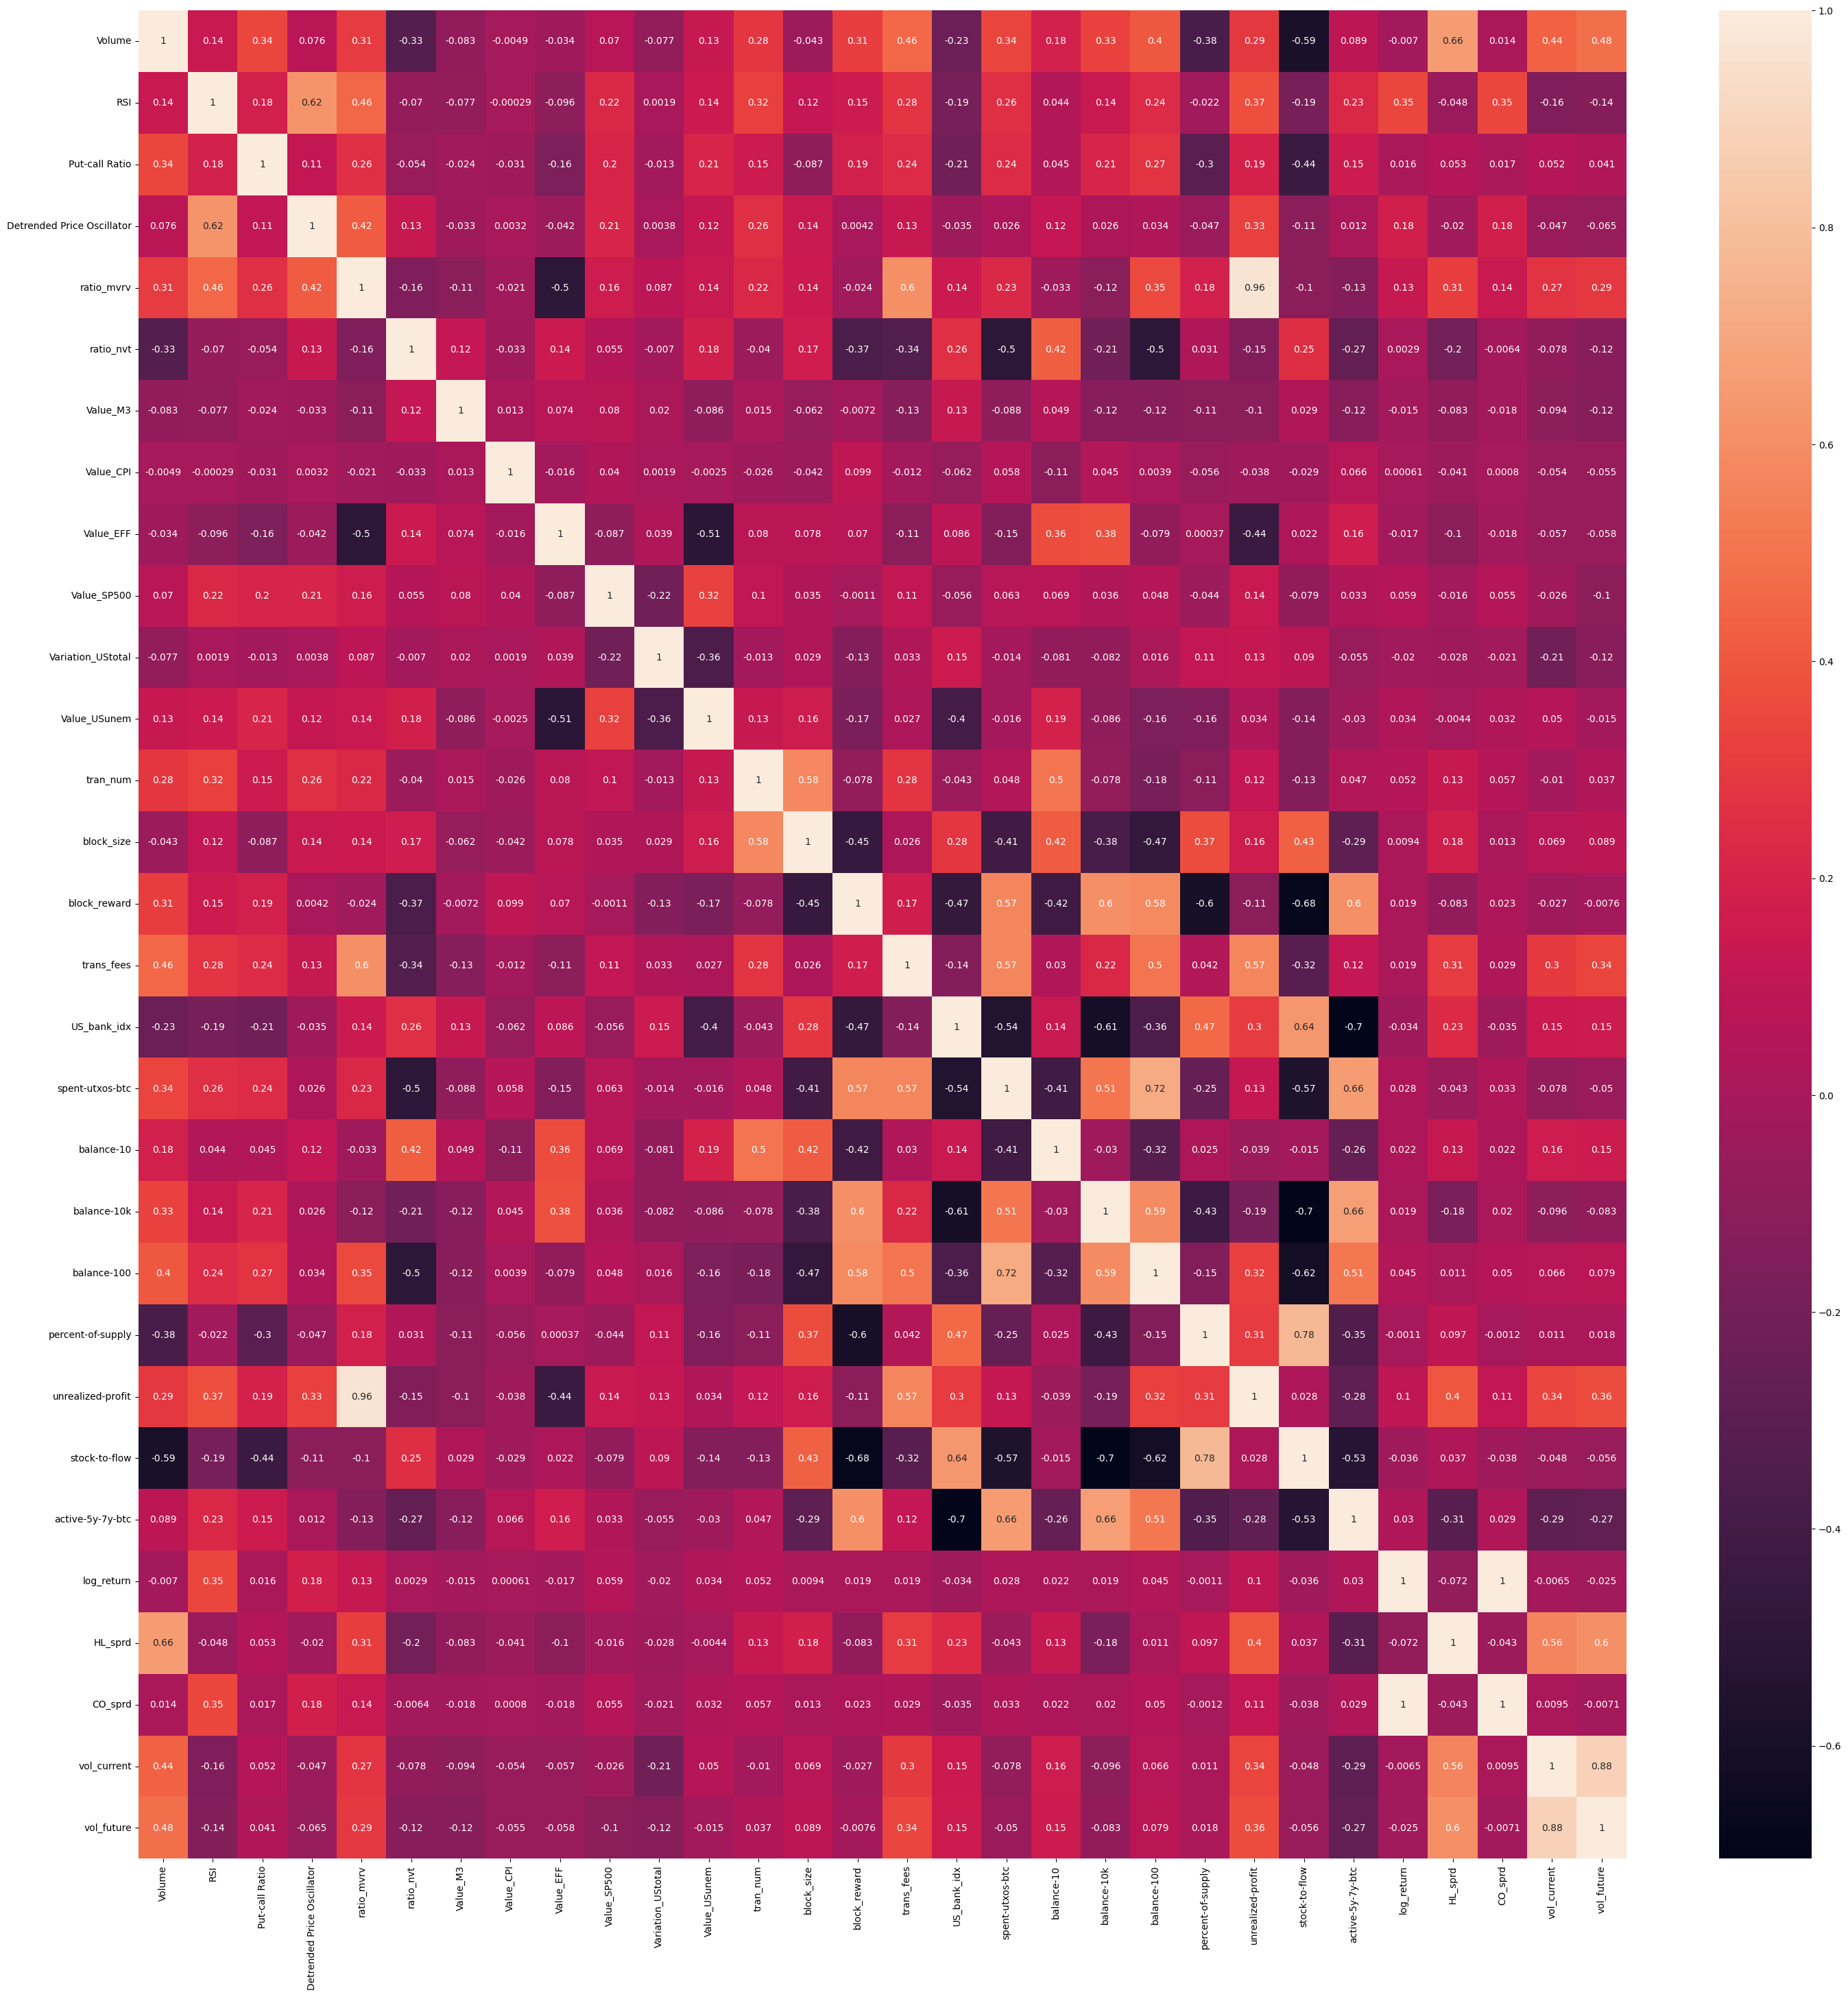

In [72]:
plt.figure(figsize=(35,35))
sns.heatmap(df_nonan_corr.corr(), annot=True)
plt.show()

In [73]:
# Assuming df is your DataFrame

# Compute the correlation matrix
corr = df_nonan_corr.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Apply the mask to get the lower triangle of the correlation matrix
corr_lower = corr.where(~mask)

# Find pairs of columns that have a correlation of 0.8 or higher, or -0.8 or lower
high_corr_pairs = [(c1, c2, corr_lower[c1][c2]) for c1 in corr_lower.columns for c2 in corr_lower.index if (abs(corr_lower[c1][c2]) > 0.65) and (c1 != c2)]

print("Highly correlated pairs with correlation values:")
for pair in high_corr_pairs:
    print(pair)

Highly correlated pairs with correlation values:
('Volume', 'HL_sprd', 0.6551322704045394)
('ratio_mvrv', 'unrealized-profit', 0.9613378901136431)
('block_reward', 'stock-to-flow', -0.6824174056002855)
('US_bank_idx', 'active-5y-7y-btc', -0.7014869068025269)
('spent-utxos-btc', 'balance-100', 0.716945820669782)
('spent-utxos-btc', 'active-5y-7y-btc', 0.6556569304007027)
('balance-10k', 'stock-to-flow', -0.7040288784702831)
('balance-10k', 'active-5y-7y-btc', 0.6635522621850062)
('percent-of-supply', 'stock-to-flow', 0.7750569124211572)
('log_return', 'CO_sprd', 0.9972670166559683)
('vol_current', 'vol_future', 0.8806276745636071)


In [74]:
df_final_corr = df_nonan_corr.drop(['stock-to-flow', 'active-5y-7y-btc', 'spent-utxos-btc'], axis=1)

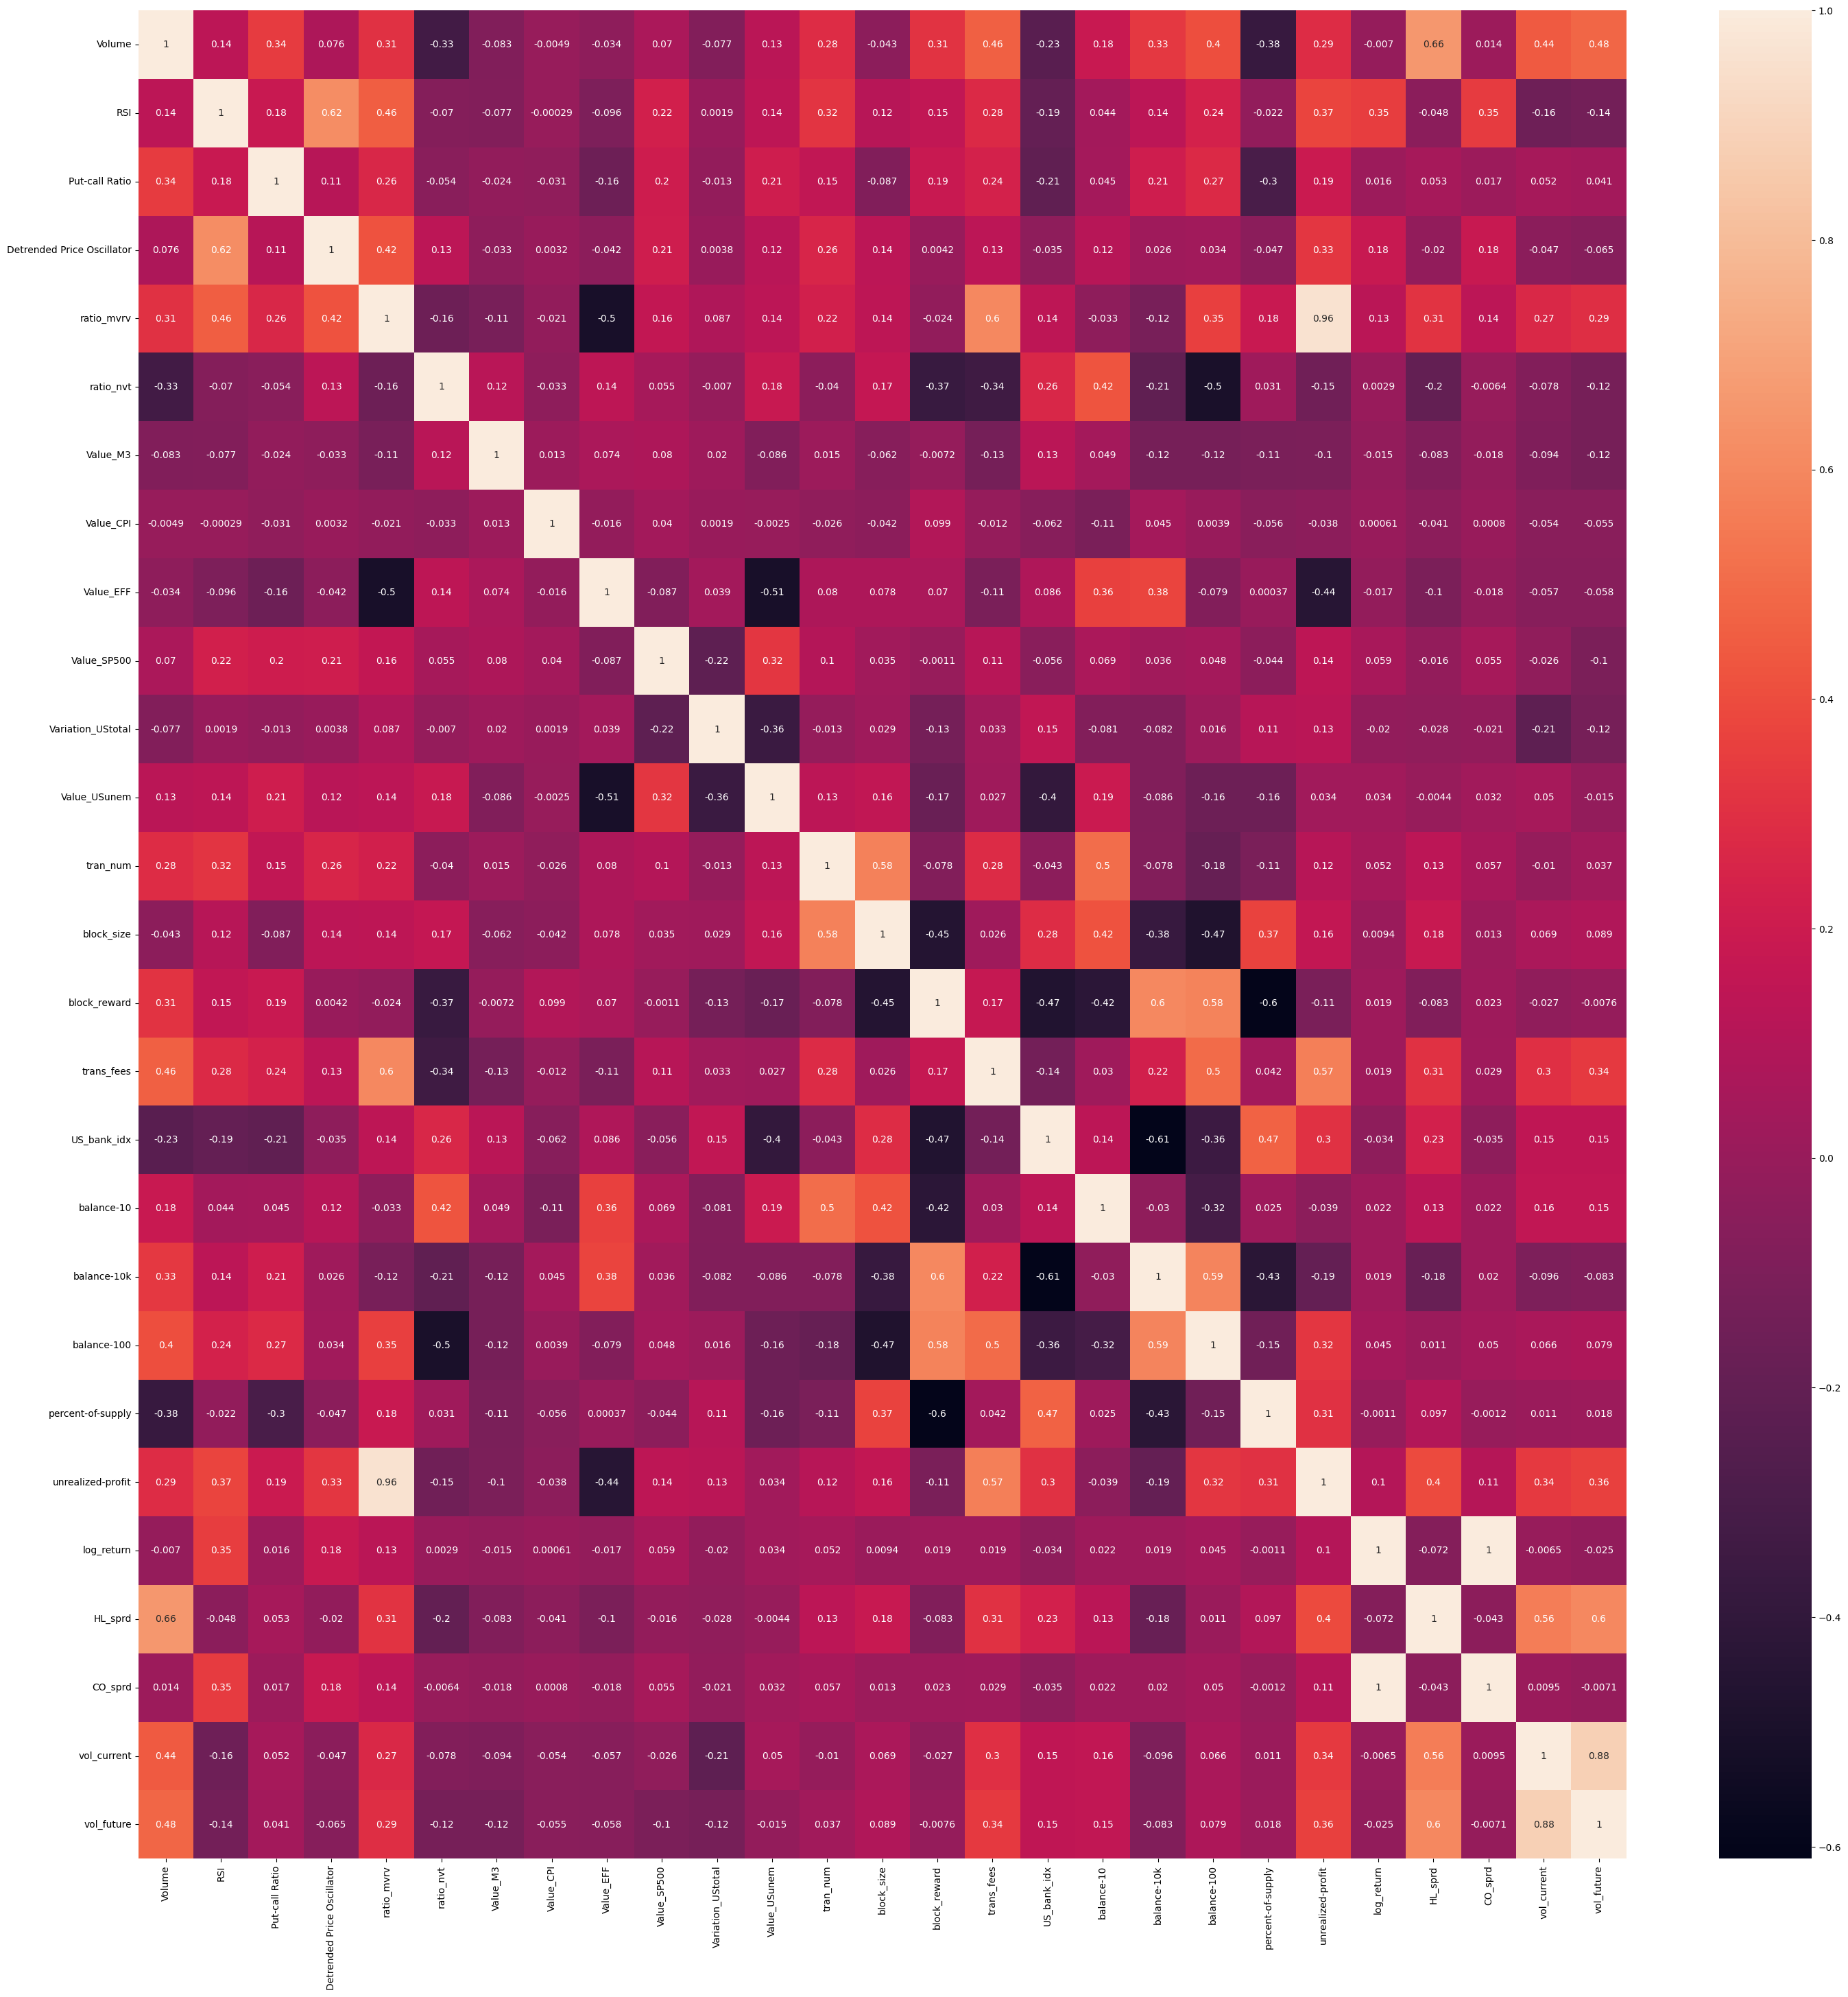

In [75]:
plt.figure(figsize=(35,35))
sns.heatmap(df_final_corr.corr(), annot=True)
plt.show()

In [77]:
df_final_corr.to_csv('../model-2/data/df_final.csv', index=True)

# Train test splits

In [80]:
df = pd.read_csv('../model-2/data/df_final.csv')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [81]:
df.columns

Index(['Volume', 'RSI', 'Put-call Ratio', 'Detrended Price Oscillator',
       'ratio_mvrv', 'ratio_nvt', 'Value_M3', 'Value_CPI', 'Value_EFF',
       'Value_SP500', 'Variation_UStotal', 'Value_USunem', 'tran_num',
       'block_size', 'block_reward', 'trans_fees', 'US_bank_idx', 'balance-10',
       'balance-10k', 'balance-100', 'percent-of-supply', 'unrealized-profit',
       'log_return', 'HL_sprd', 'CO_sprd', 'vol_current', 'vol_future'],
      dtype='object')

In [82]:
#update numerical & target features

target = ['vol_future']
numerical_feat = df.drop('vol_future', axis=1).columns

In [83]:
# validation/test splits
test_size = 30
val_size = 365

# to index
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [84]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2016-03-30 00:00:00 	to: 2022-01-23 00:00:00 	2126 days
VALIDATION 	From: 2022-01-24 00:00:00 	to: 2023-01-23 00:00:00 	365 days
TEST 		From: 2023-01-24 00:00:00 	to: 2023-02-22 00:00:00 	30 days


In [85]:
# Y (target) 3 splits
y_train = df.loc[train_idx][target]
y_val = df.loc[val_idx][target]
y_test = df.loc[test_idx][target]

In [86]:
# X 3 splits
x_train = df.loc[train_idx].drop('vol_future', axis=1)
x_val = df.loc[val_idx].drop('vol_future', axis=1)
x_test = df.loc[test_idx].drop('vol_future', axis=1)

In [87]:
# for visualization
x_train_vol = df.vol_current[train_idx]
x_val_vol = df.vol_current[val_idx]
x_test_vol = df.vol_current[test_idx]

In [88]:
print(len(y_train), len(x_train))
print(len(y_val), len(x_val))
print(len(y_test), (len(x_test)))

2126 2126
365 365
30 30


In [89]:
y_train.describe()

vol_future
count  2126.000000
mean      0.038098
std       0.016986
min       0.006711
25%       0.027734
50%       0.035705
75%       0.047482
max       0.110288

In [90]:
x_train.describe()

Volume          RSI  Put-call Ratio  Detrended Price Oscillator   
count  2126.000000  2126.000000     2126.000000                 2126.000000  \
mean      8.742340    54.637769      510.204869                  414.406790   
std       0.794928    14.309208      425.833499                 3753.302396   
min       3.614623     9.632983        0.610000               -20204.532857   
25%       8.212119    44.612956        1.082000                 -410.758095   
50%       8.772703    53.975590      761.000000                   65.263333   
75%       9.313856    64.439103      884.000000                 1066.630952   
max      11.169891    94.020499      999.000000                21465.031905   

        ratio_mvrv    ratio_nvt     Value_M3    Value_CPI    Value_EFF   
count  2126.000000  2126.000000  2126.000000  2126.000000  2126.000000  \
mean      1.944446    24.821227     0.709276     1.866716     0.989262   
std       0.689377    14.033573     2.574342    25.791954     0.842341   
min       0.699270     2.016091    -0.899724    -0.986803     0.050000   
25%       1.453777    12.430804     0.003232    -0.122412     0.090000   
50%       1.802021    24.178882     0.005151     0.047097     0.900000   
75%       2.332417    32.664909     0.010992     0.205059     1.700000   
max       4.850245    87.176566     9.094759   836.626449     2.420000   

       Value_SP500  ...  US_bank_idx     balance-10  balance-10k   
count  2126.000000  ...  2126.000000    2126.000000  2126.000000  \
mean      1.243170  ...   437.995828  149292.118062   108.065851   
std       4.190054  ...    83.263873    4208.858432    11.114734   
min     -12.510000  ...   263.420000  134464.000000    81.000000   
25%      -0.120000  ...   391.495000  147671.500000   104.000000   
50%       1.790000  ...   437.275000  149370.500000   110.000000   
75%       3.420000  ...   488.180000  152497.500000   116.000000   
max      12.680000  ...   638.540000  157275.000000   126.000000   

        balance-100  percent-of-supply  unrealized-profit   log_return   
count   2126.000000        2126.000000        2126.000000  2126.000000  \
mean   16868.121825           0.307725           0.506599     0.002102   
std      836.352212           0.035520           0.108418     0.041032   
min    15838.000000           0.247219           0.305923    -0.493969   
25%    16129.250000           0.273796           0.421030    -0.014156   
50%    16503.000000           0.294318           0.488592     0.002128   
75%    17475.000000           0.347554           0.587333     0.020362   
max    18543.000000           0.381434           0.793415     0.238396   

           HL_sprd      CO_sprd  vol_current  
count  2126.000000  2126.000000  2126.000000  
mean     -3.101320     0.002985     0.038034  
std       0.720664     0.040678     0.017051  
min      -6.337447    -0.391466     0.006711  
25%      -3.563481    -0.013925     0.027650  
50%      -3.067326     0.002073     0.035705  
75%      -2.628824     0.020833     0.047482  
max      -0.416202     0.269043     0.110288  

[8 rows x 26 columns]

In [91]:
# scale data
scaler_vol = MinMaxScaler()

scaler_vol = scaler_vol.fit(x_train_vol.values.reshape(-1,1))

In [92]:
x_train_scaled = um.transform_volatility_to_scaler(scaler_vol, x_train_vol)
y_train_scaled = um.transform_volatility_to_scaler(scaler_vol, y_train)

x_val_scaled = um.transform_volatility_to_scaler(scaler_vol, x_val_vol)
y_val_scaled = um.transform_volatility_to_scaler(scaler_vol, y_val)

x_test_scaled = um.transform_volatility_to_scaler(scaler_vol, x_test_vol)
y_test_scaled = um.transform_volatility_to_scaler(scaler_vol, y_test)

In [93]:
y_train.head(10)

vol_future
time                  
2016-03-30    0.008703
2016-03-31    0.008655
2016-04-01    0.008695
2016-04-02    0.008593
2016-04-03    0.008479
2016-04-04    0.007874
2016-04-05    0.007913
2016-04-06    0.007896
2016-04-07    0.007898
2016-04-08    0.008139

In [94]:
y_train_scaled.head(10)

time
2016-03-30    0.019235
2016-03-31    0.018776
2016-04-01    0.019153
2016-04-02    0.018171
2016-04-03    0.017077
2016-04-04    0.011229
2016-04-05    0.011612
2016-04-06    0.011447
2016-04-07    0.011458
2016-04-08    0.013793
dtype: float64

In [95]:
x_train_scaled.head(10)

time
2016-03-30    0.055122
2016-03-31    0.054657
2016-04-01    0.048704
2016-04-02    0.048496
2016-04-03    0.035249
2016-04-04    0.028440
2016-04-05    0.025576
2016-04-06    0.019235
2016-04-07    0.018776
2016-04-08    0.019153
dtype: float64

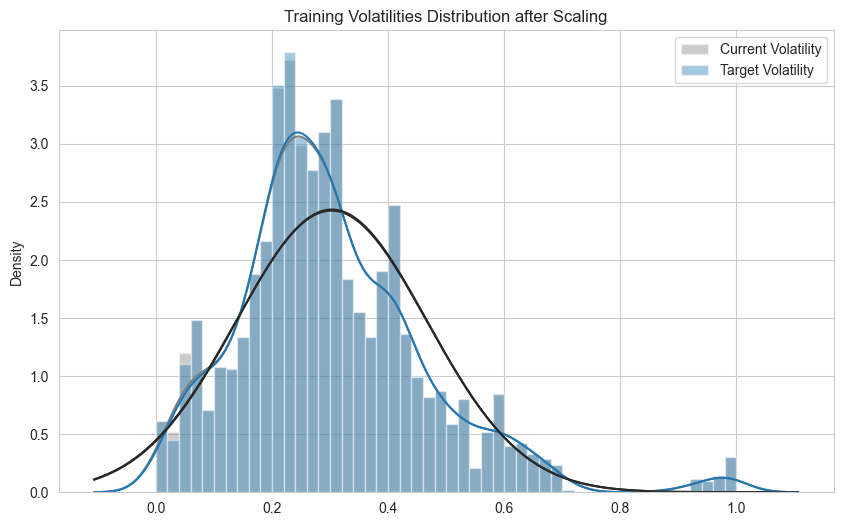

In [96]:
# volatility after scaling 
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    plt.show()

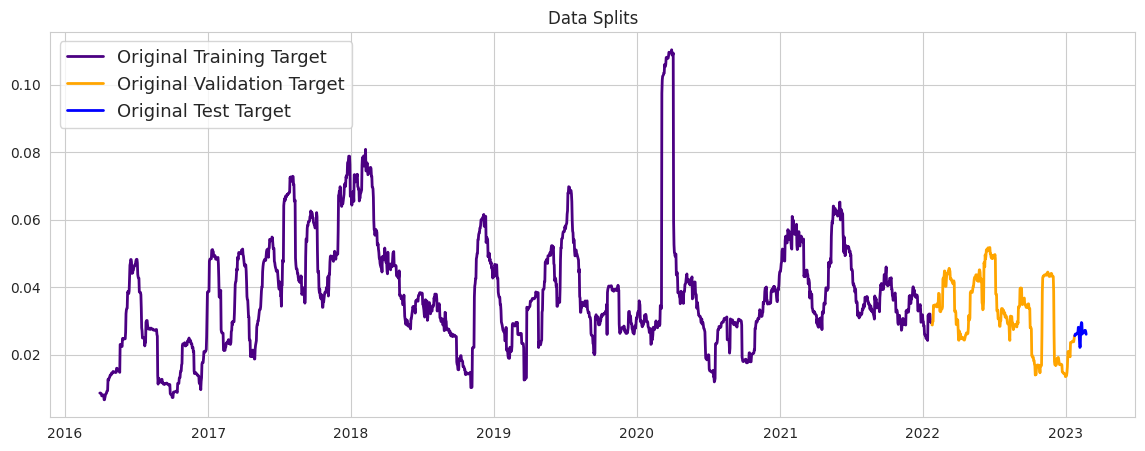

In [97]:
# plot splits train-val-test

with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(figsize=(14,5))

    #ax1.plot(df.vol_current, lw=1, color='indigo', ls='--',
                #label='Current Volatility')
    ax1.plot(y_train, color='indigo', label='Original Training Target', lw=2)
    ax1.plot(y_val, color='orange', label='Original Validation Target', lw=2)
    ax1.plot(y_test, color='blue', label='Original Test Target', lw=2)

    ax1.title.set_text('Data Splits')

    # ax2.plot(um.transform_volatility_to_scaler(scaler_vol, df.vol_current), 
    #             lw=1, color='gray', ls='--',
    #             label='Scaled Current Volatility')
    # ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=2)
    # ax2.plot(y_val_scaled, color='orange', label='Scaled Validation Target', lw=2)
    # ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=2)

    # ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    # ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    # plt.show()

# Features importance
* Lineal regression importances first approach

In [98]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE


# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBModel as xgb

#from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [99]:
# Features/target split
X = df.drop(target, axis=1)
y = df[target]

x_transf = X.copy()
x_val_transf = x_val.copy()

# Standarize the data to improve the regression's performance
scaler = MinMaxScaler()
x_transf[numerical_feat] = scaler.fit_transform(X[numerical_feat])
x_val_transf[numerical_feat] = scaler.transform(x_val[numerical_feat])

In [100]:
# Feature importance RFE with linear regression
model = LinearRegression( n_jobs=-1)
selector = RFE(model, n_features_to_select=5, step=1)
selector = selector.fit(x_transf, y)

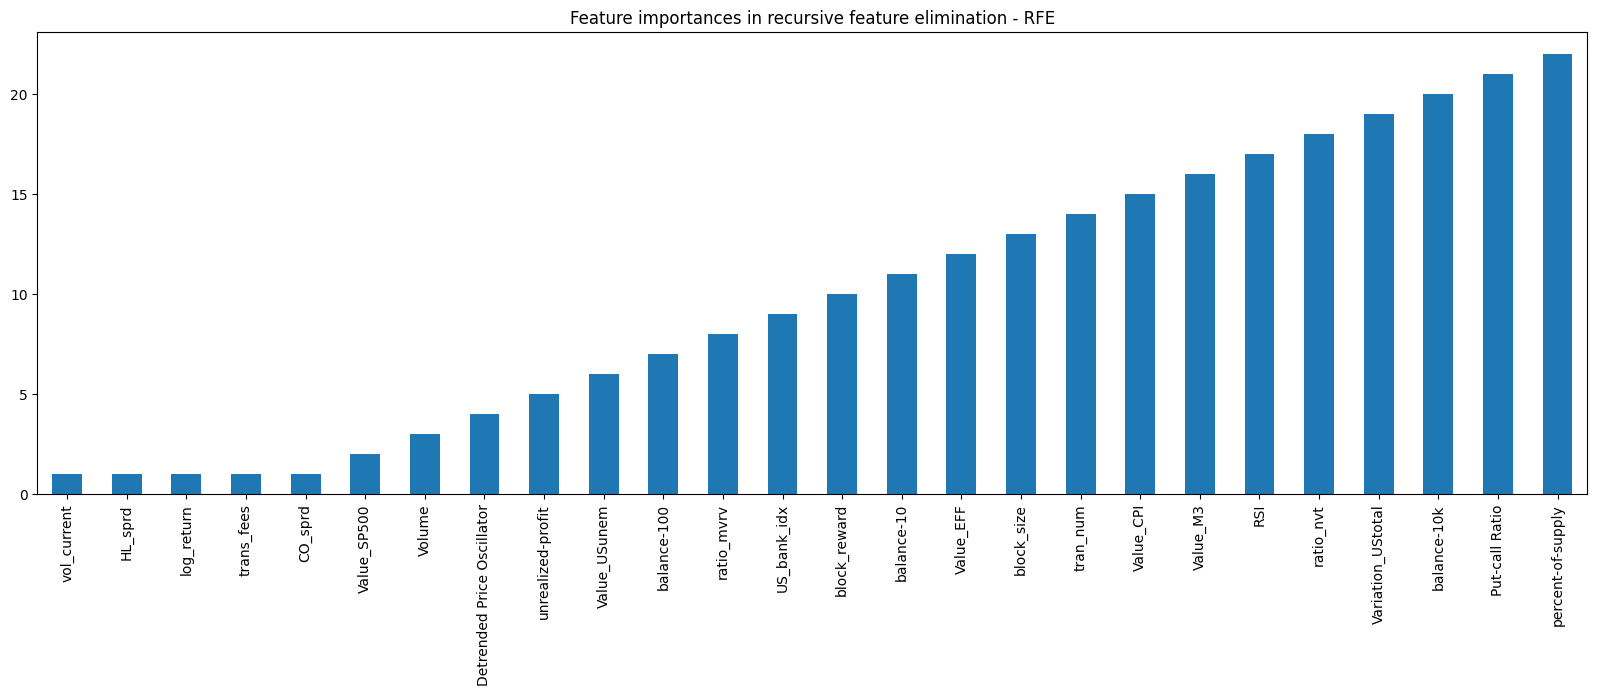

In [101]:
# Feature importances plot
importances = selector.ranking_
sorted_importances = pd.Series(importances, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(20,6))
sorted_importances.plot.bar()
plt.title("Feature importances in recursive feature elimination - RFE")
plt.show()

In [102]:
list(sorted_importances.index)

['vol_current',
 'HL_sprd',
 'log_return',
 'trans_fees',
 'CO_sprd',
 'Value_SP500',
 'Volume',
 'Detrended Price Oscillator',
 'unrealized-profit',
 'Value_USunem',
 'balance-100',
 'ratio_mvrv',
 'US_bank_idx',
 'block_reward',
 'balance-10',
 'Value_EFF',
 'block_size',
 'tran_num',
 'Value_CPI',
 'Value_M3',
 'RSI',
 'ratio_nvt',
 'Variation_UStotal',
 'balance-10k',
 'Put-call Ratio',
 'percent-of-supply']

In [103]:
# Feature importance RFE with linear regression
model = DecisionTreeRegressor()
selector = RFE(model, n_features_to_select=5, step=1)
selector = selector.fit(x_transf, y)

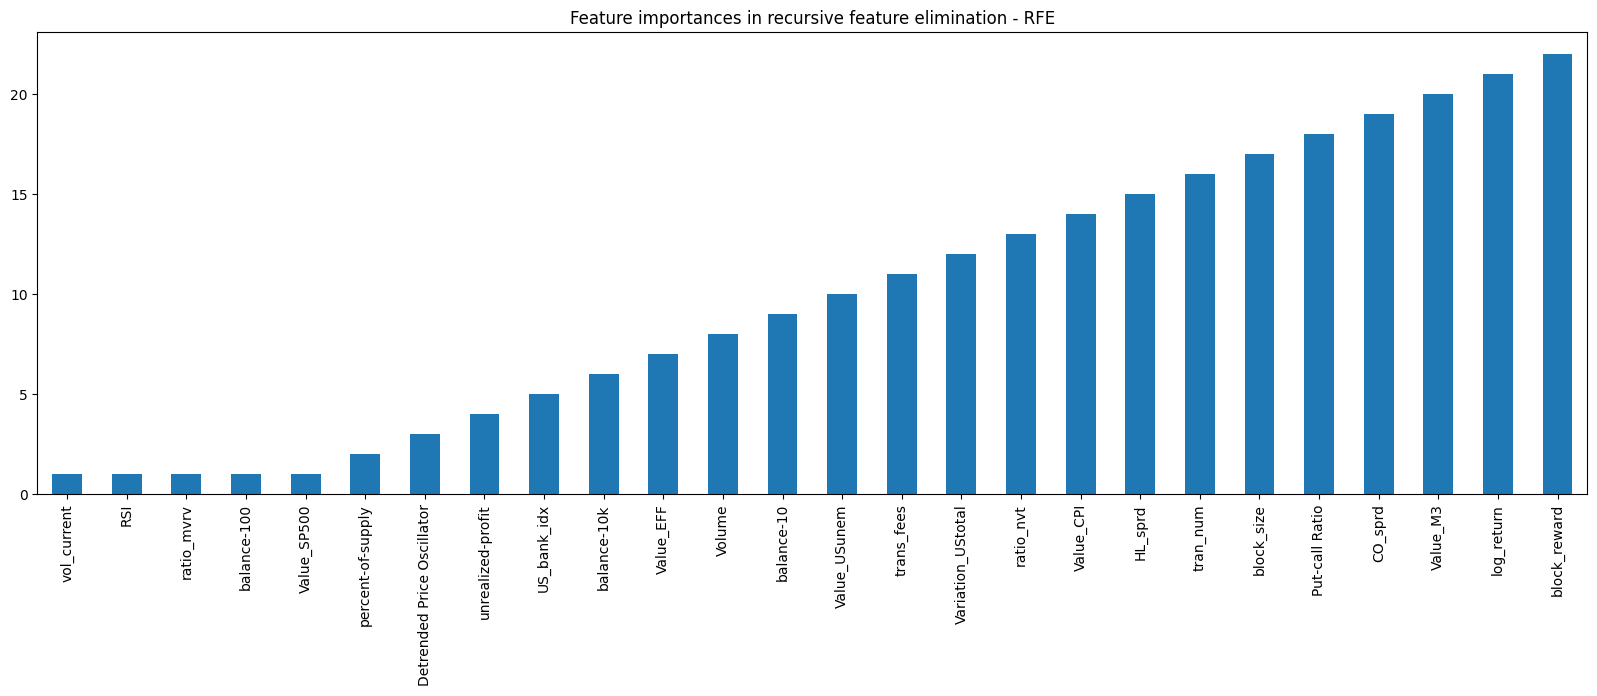

In [104]:
# Feature importances plot
importances = selector.ranking_
sorted_importances = pd.Series(importances, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(20,6))
sorted_importances.plot.bar()
plt.title("Feature importances in recursive feature elimination - RFE")
plt.show()

In [105]:
list(sorted_importances.index)

['vol_current',
 'RSI',
 'ratio_mvrv',
 'balance-100',
 'Value_SP500',
 'percent-of-supply',
 'Detrended Price Oscillator',
 'unrealized-profit',
 'US_bank_idx',
 'balance-10k',
 'Value_EFF',
 'Volume',
 'balance-10',
 'Value_USunem',
 'trans_fees',
 'Variation_UStotal',
 'ratio_nvt',
 'Value_CPI',
 'HL_sprd',
 'tran_num',
 'block_size',
 'Put-call Ratio',
 'CO_sprd',
 'Value_M3',
 'log_return',
 'block_reward']

In [106]:
selected_features = [
'vol_current',
 'ratio_mvrv',
 'balance-100',
 'Value_SP500',
 'balance-10',
 'Detrended Price Oscillator',
 'RSI',
 'percent-of-supply',
 'balance-10k',
 'unrealized-profit',
 'Value_EFF',
 'Volume',
 'US_bank_idx',
 'Variation_UStotal',
 'Value_USunem',
 'ratio_nvt',
 'trans_fees',
 'Value_CPI',
 'HL_sprd',
 'tran_num'
#  'block_size',
#  'Put-call Ratio',
#  'Value_M3',
#  'block_reward',
#  'log_return',
#  'CO_sprd'
]

# Cross-val con varios modelos

In [107]:
""" Realizaremos un análisis de los siguientes modelos con las siguentes features """

seed = 42

models = []
models.append(('LR', LinearRegression()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('KNR', KNeighborsRegressor()))
models.append(('RFR', RandomForestRegressor(random_state=seed, n_jobs = -1)))
models.append(('GBR', GradientBoostingRegressor(random_state=seed)))
models.append(('XGB', xgb(random_state=seed)))
#models.append(('LGBM', LGBMRegressor(random_state=seed)))
models.append(('CATBOOST', CatBoostRegressor(random_state=seed)))

metrics = []
metrics.append(('RMSE','neg_root_mean_squared_error'))

In [108]:
""" Para plotear los resultados utilizaremos la siguiente función """
def boxplots_algorithms(results, names, metric):
        
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.title(metric)
    plt.show()

LR: -0.028882 (0.026702)
DTR: -0.012728 (0.003171)
KNR: -0.019583 (0.005324)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks

RFR: -0.010476 (0.004536)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:43

GBR: -0.010391 (0.004262)
XGB: -0.010816 (0.003352)
Learning rate set to 0.044445
Learning rate set to 0.039838
Learning rate set to 0.046039
Learning rate set to 0.035712
Learning rate set to 0.042471
0:	learn: 0.0167483	total: 62.1ms	remaining: 1m 2s
0:	learn: 0.0129375	total: 62.4ms	remaining: 1m 2s
0:	learn: 0.0165193	total: 63.4ms	remaining: 1m 3s
0:	learn: 0.0177990	total: 64.1ms	remaining: 1m 4s
1:	learn: 0.0162075	total: 65.6ms	remaining: 32.7s
0:	learn: 0.0181563	total: 66.5ms	remaining: 1m 6s
1:	learn: 0.0126128	total: 67.2ms	remaining: 33.5s
1:	learn: 0.0172042	total: 67.4ms	remaining: 33.7s
1:	learn: 0.0159919	total: 67.6ms	remaining: 33.7s
2:	learn: 0.0156842	total: 68.7ms	remaining: 22.8s
1:	learn: 0.0176177	total: 69.6ms	remaining: 34.7s
2:	learn: 0.0166871	total: 70.1ms	remaining: 23.3s
2:	learn: 0.0122986	total: 72ms	remaining: 23.9s
2:	learn: 0.0154935	total: 72.5ms	remaining: 24.1s
3:	learn: 0.0152137	total: 72.3ms	remaining: 18s
3:	learn: 0.0161820	total: 72.9ms	rem

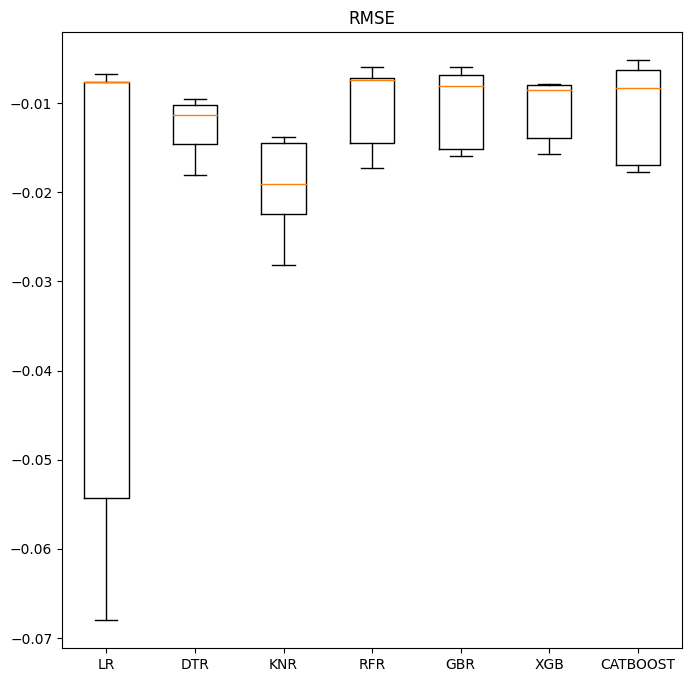

In [109]:
from sklearn.model_selection import TimeSeriesSplit


for metric, scoring in metrics:
    results = []
    names = []
    for name, model in models:

        cv_technique = TimeSeriesSplit()
        cv_results = cross_val_score(model,                 # Pipeline
                                     X[selected_features],  # Feature matrix
                                     y,                     # Target vector
                                     cv=cv_technique,       # Cross-validation technique
                                     scoring=scoring,       # Scoring
                                     n_jobs = -1) 

        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

        results.append(cv_results)
        names.append(name)

    boxplots_algorithms(results, names, metric)

# Modeling

### Results:

In [110]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

## Xgboost

In [111]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, RepeatedKFold, cross_val_score
from sklearn.metrics import fbeta_score, accuracy_score, confusion_matrix, recall_score, precision_score
from xgboost import plot_importance

In [112]:
# define model
xg = xgb()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xg, X[selected_features], y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.5f (%.5f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.00263 (0.00025)


In [113]:
xg.fit(x_train[selected_features], y_train)

XGBModel()

In [114]:
# make a prediction
y_pred_xg = xg.predict(x_val[selected_features])

In [115]:
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error

# calculate manually
d = y_val['vol_future'] - y_pred_xg

mse_f = mean_squared_error(y_val['vol_future'], y_pred_xg)
rmse_f = np.sqrt(mse_f)
r2_f = r2_score(y_val['vol_future'], y_pred_xg)

print("MSE:", mse_f)
print("RMSE:", rmse_f)
print("R-Squared:", r2_f)

MSE: 5.310972738585195e-05
RMSE: 0.0072876421005598204
R-Squared: 0.4935907167981416


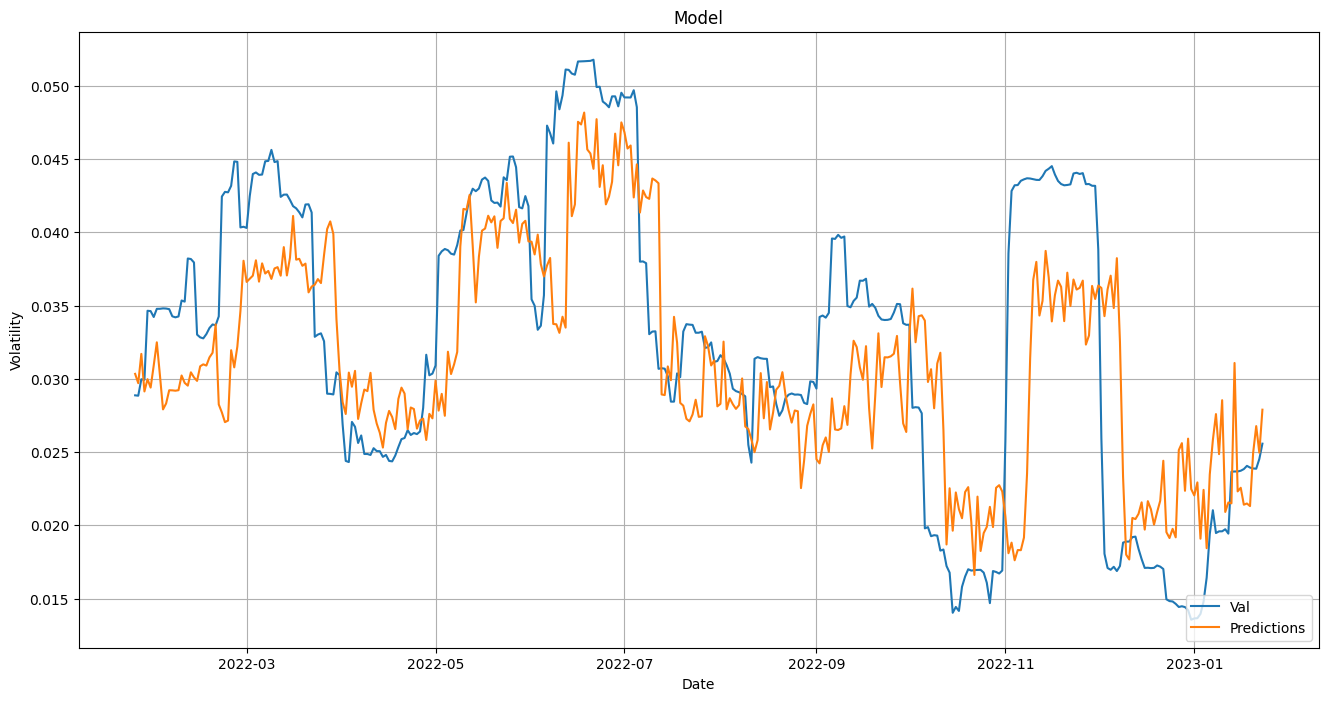

In [116]:
# dic = {'vol_future': y_val_scaled}
# validation = pd.DataFrame(dic)

validation = y_val
validation['Predictions'] = y_pred_xg
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')

plt.ylabel('Volatility')
#plt.plot(train)

plt.plot(validation[['vol_future', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.grid()
plt.show()

In [117]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
um.log_perf(y_val['vol_future'], y_pred_xg,
        "xgboost", perf_df=perf_df)

Model  Validation RMSPE  Validation RMSE
0  xgboost          0.268343         0.007288

## Catboost

In [118]:
# define model
cb = CatBoostRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(cb, X[selected_features], y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

cb.fit(x_train[selected_features], y_train)

Learning rate set to 0.046598
Learning rate set to 0.046602
0:	learn: 0.0157444	total: 2.61ms	remaining: 2.61s
0:	learn: 0.0156932	total: 2.83ms	remaining: 2.83s
1:	learn: 0.0151802	total: 5.71ms	remaining: 2.85s
1:	learn: 0.0152692	total: 5.83ms	remaining: 2.91s
Learning rate set to 0.046602
2:	learn: 0.0147952	total: 8.6ms	remaining: 2.86s
2:	learn: 0.0147081	total: 8.77ms	remaining: 2.92s
3:	learn: 0.0143400	total: 11ms	remaining: 2.75s
3:	learn: 0.0142558	total: 11.2ms	remaining: 2.78s
0:	learn: 0.0154745	total: 3.86ms	remaining: 3.86s
4:	learn: 0.0138225	total: 14.8ms	remaining: 2.94s
1:	learn: 0.0150050	total: 7.07ms	remaining: 3.53s
4:	learn: 0.0139037	total: 16.6ms	remaining: 3.29s
5:	learn: 0.0133978	total: 18.9ms	remaining: 3.12s
5:	learn: 0.0134822	total: 19.1ms	remaining: 3.16s
2:	learn: 0.0145628	total: 12.3ms	remaining: 4.07s
6:	learn: 0.0129928	total: 21.7ms	remaining: 3.07s
6:	learn: 0.0130773	total: 22.5ms	remaining: 3.19s
7:	learn: 0.0126023	total: 24.6ms	remaining: 3

In [119]:
# make a predictionç
y_pred_cat = cb.predict(x_val[selected_features])

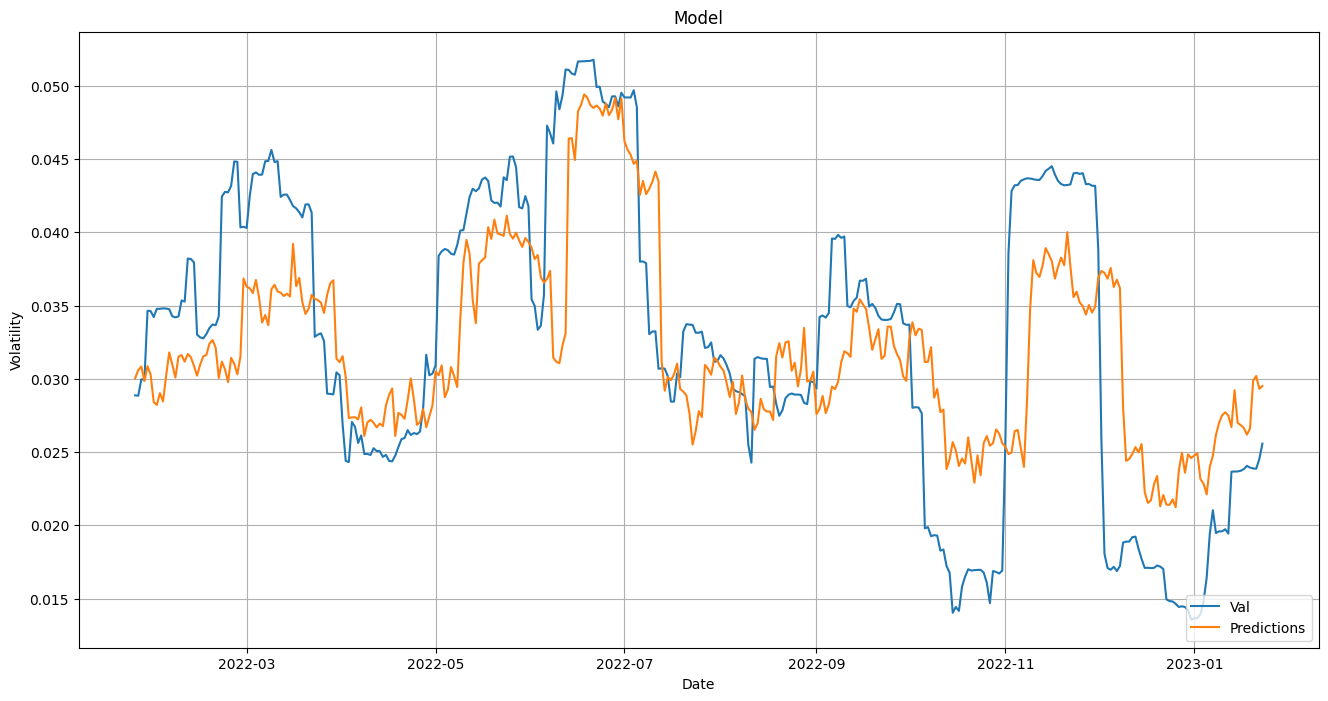

In [120]:
validation = y_val
validation['Predictions'] = y_pred_cat
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')

plt.ylabel('Volatility')
#plt.plot(train)

plt.plot(validation[['vol_future', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.grid()
plt.show()

In [121]:
# append metrics to perf_df 
um.log_perf(y_val['vol_future'], y_pred_cat,
        "catboost", perf_df=perf_df)

Model  Validation RMSPE  Validation RMSE
0   xgboost          0.268343         0.007288
1  catboost          0.292853         0.007015

## LSTM

In [122]:
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

In [123]:
#SUBDATASETS

#features_1 = df.drop('vol_future', axis=1).columns

features_0 = ['HL_sprd', 'trans_fees', 'Volume', 'vol_current']

features_irene1 = [ 'block_reward', 'trans_fees', 'vol_current', 'Volume']

#best model
features_irene2 = [ 'Volume', 'HL_sprd', 'trans_fees', 'vol_current',]

features_irene3 = [ 'Volume', 'HL_sprd', 'Value_SP500', 'vol_current']

features_irene4  = ['vol_current', 'ratio_mvrv', 'HL_sprd', 'trans_fees', 'Volume'] 

features_irene5 = ['vol_current', 'unrealized-profit', 'Value_SP500', 'percent-of-supply']

features_irene6 = [ 'Volume', 'HL_sprd', 'Detrended Price Oscillator', 'vol_current',  'unrealized-profit']

features_irene7 = ['Volume', 'HL_sprd',  'unrealized-profit', 'Value_USunem', 'balance-100', 'vol_current',
  'US_bank_idx']

features_irene8 = ['Volume', 'HL_sprd', 'vol_current', 'Detrended Price Oscillator', 'unrealized-profit',
  'US_bank_idx', 'block_reward', 'balance-10', 'tran_num',  'block_size']

lista_larga= [
 'Volume',
 'HL_sprd',
 'trans_fees',
 'Value_SP500',
 'vol_current',
 'Detrended Price Oscillator',
 'unrealized-profit',
 'Value_USunem',
 'balance-100',
 'US_bank_idx',
 'block_reward',
 'balance-10',
 'tran_num',
 'block_size',
 'Value_EFF',
 'Value_CPI',
 'Value_M3',
 'CO_sprd',
 'ratio_nvt',
 'Variation_UStotal',
 'RSI',
 'percent-of-supply',
 'balance-10k',
 'Put-call Ratio'
]



list_feat = [features_0, features_irene1, features_irene2, features_irene4, 
             features_irene5, features_irene6, features_irene7, features_irene8]



In [124]:
#SUBDATASETS

#features_1 = df.drop('vol_future', axis=1).columns

features_0 = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']

#best model
features_1 = [ 'Volume', 'HL_sprd', 'trans_fees', 'vol_current',]

features_2 = [ 'Volume', 'HL_sprd', 'Detrended Price Oscillator', 'vol_current']
features_3 = [ 'Volume', 'HL_sprd', 'ratio_mvrv', 'vol_current']
features_4 = [ 'Volume', 'HL_sprd', 'balance-100', 'vol_current']
features_5 = [ 'Volume', 'HL_sprd', 'US_bank_idx', 'vol_current']
features_6 = [ 'Volume', 'HL_sprd', 'unrealized-profit', 'vol_current']
features_7 = [ 'Volume', 'trans_fees', 'ratio_mvrv', 'vol_current']
features_8  = ['vol_current', 'ratio_mvrv', 'HL_sprd', 'trans_fees', 'Volume'] 
features_9 = ['vol_current', 'unrealized-profit', 'Value_SP500', 'trans_fees']
features_10 = [ 'Volume', 'HL_sprd', 'trans_fees', 'vol_current',  'unrealized-profit']
features_11 = ['Volume', 'HL_sprd',  'unrealized-profit', 'Value_USunem', 'balance-100', 'vol_current',
  'US_bank_idx']
features_12 = ['unrealized-profit', 'vol_current', 'block_reward', 'trans_fees']
features_13 = ['Volume', 'HL_sprd', 'vol_current', 'block_reward', 'tran_num']
features_14 = ['Volume', 'HL_sprd', 'vol_current', 'block_reward', 'balance-10', 'tran_num']
features_15 = [ 'Volume', 'HL_sprd', 'Value_USunem', 'vol_current']
features_16 = [ 'vol_current', 'Detrended Price Oscillator', 'unrealized-profit', 'Value_USunem']
features_17 = [ 'Volume',
 'HL_sprd',
 'trans_fees',
 'Value_SP500',
 'vol_current',
 'Detrended Price Oscillator',
 'unrealized-profit',
 'Value_USunem',
 'balance-100']
features_18 = [ 'vol_current',
 'Detrended Price Oscillator',
 'unrealized-profit',
 'Value_USunem',
 'balance-100',
 'US_bank_idx',
 'block_reward',
 'balance-10']
features_19 = [ 'vol_current','US_bank_idx',
 'block_reward',
 'balance-10',
 'tran_num',
 'block_size',
 'Value_EFF',
 'Value_CPI',
 'Value_M3',
 'CO_sprd']
features_20 = ['vol_current',
     'CO_sprd',
 'ratio_nvt',
 'Variation_UStotal',
 'RSI',
 'percent-of-supply',
 'balance-10k',
 'Put-call Ratio'
]


lista_larga= [
 'Volume',
 'HL_sprd',
 'trans_fees',
 'Value_SP500',
 'vol_current',
 'Detrended Price Oscillator',
 'unrealized-profit',
 'Value_USunem',
 'balance-100',
 'US_bank_idx',
 'block_reward',
 'balance-10',
 'tran_num',
 'block_size',
 'Value_EFF',
 'Value_CPI',
 'Value_M3',
 'CO_sprd',
 'ratio_nvt',
 'Variation_UStotal',
 'RSI',
 'percent-of-supply',
 'balance-10k',
 'Put-call Ratio'
]



list_feat = [features_0, features_1, features_2, features_3, features_4, features_5,features_6,features_7,features_8,features_9, 
             features_10, features_11, features_12, features_13, features_14, features_15, features_16, features_17,features_18,
             features_19,features_20]


In [125]:
list_feat = [features_0]

### BI-LSTM 2 Layers

In [126]:
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        
        plt.plot(y_true, color='indigo', lw=1, 
                label=f"Target Volatility", marker='.')
        plt.plot(y_pred, color='orange', lw=1.5,
                label=f'Forecasted Volatility', marker='.')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

2023-07-14 15:27:44.499806: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


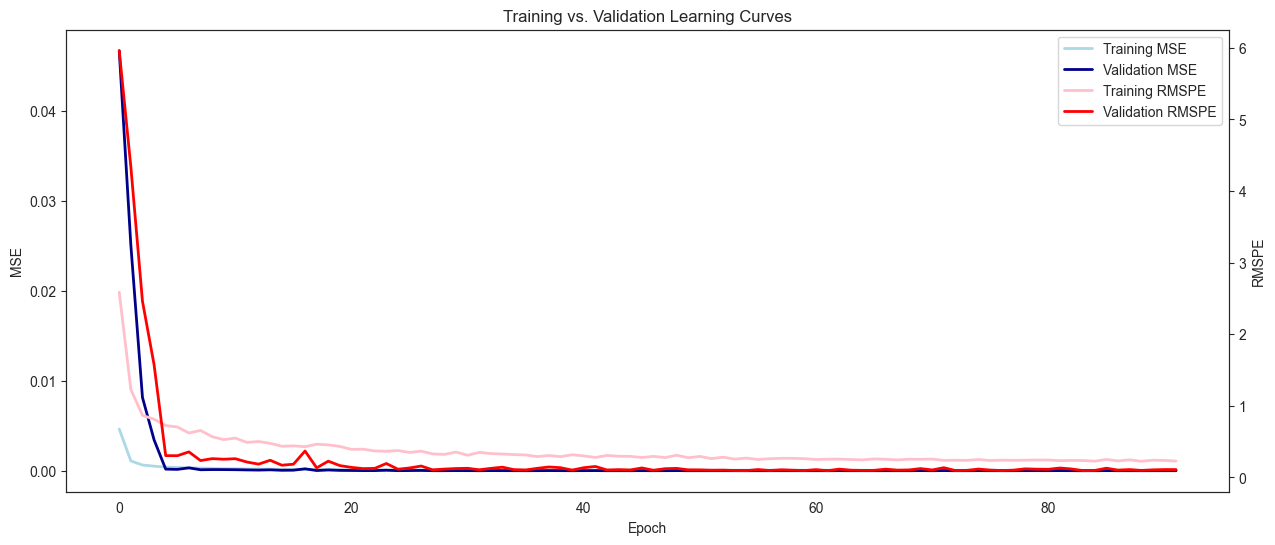

2022-01-24 00:00:00
12/12 [==============================] - 1s 2ms/step


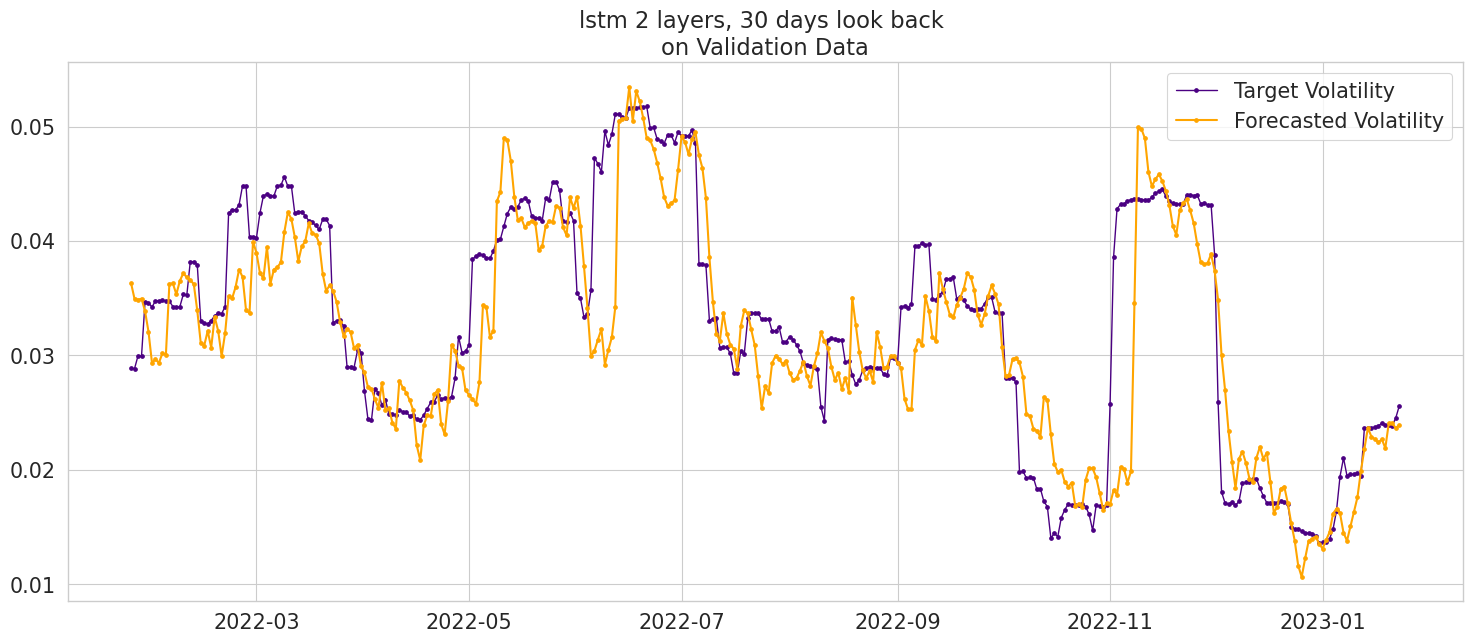

In [127]:
i = 0 # for perf_df

#loop subdatasets
for features in list_feat: 
    
    # SEPARATE INPUT DATAFRAME FROM df
    input_df = df[features]

    # SEPARATE INPUTS FOR TRAINING SET ONLY
    X_train = input_df.loc[train_idx]

    seed=1234

    tf.keras.backend.clear_session()

    # Seed for reproducibility
    np.random.seed(seed)

    n_past = 30
    batch_size = 64
    n_dims = input_df.shape[1]

    mat_X_train, mat_y_train = um.windowed_dataset(X_train, y_train['vol_future'], n_past)

    # CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
    lstm_2 = tf.keras.models.Sequential([ 
        tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
        # BATCH NORMALIZATION
        tf.keras.layers.BatchNormalization(), 

        # ADDING 1st LSTM LAYER
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Dropout(0.1),


        # ADDING 3nd LSTM LAYER
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Dropout(0.1),

        # DENSE OUTPUT LAYER
        tf.keras.layers.Dense(1)
    ])

    lstm_2.compile(loss='mse', 
                optimizer="adam", 
                metrics=[um.rmspe])

    #saving model
    checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                    save_best_only=True,
                                    monitor='val_rmspe')

    # stopping the training if validation rmspe is not improving    
    early_stopping_cb = EarlyStopping(patience=30,
                                    restore_best_weights=True,
                                    monitor='val_rmspe')



        # fitting training data
    lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                            callbacks=[checkpoint_cb, early_stopping_cb],
                                validation_split=0.2, shuffle=True,
                            verbose=0, batch_size=batch_size, epochs=200)


    # learning curves
    um.viz_train_val_metrics(lstm_2_res)

    # forecasting on validation set
    lstm_2_preds = um.forecast_multi(lstm_2, val_idx, input_df=input_df, df=df, n_past=n_past)

    # test scaling
    lstm_2_preds_scaled = um.scale(scaler_vol, lstm_2_preds)

    # plotting predictions-target
    viz_model(y_val['vol_future'], lstm_2_preds, 
            f"lstm 2 layers, 30 days look back")
    plt.show()


    ## append metrics to perf_df 
    um.log_perf(y_val['vol_future'], lstm_2_preds,
         f"lstm 2 layers {i}", perf_df=perf_df)
    
    i = i+1

In [128]:
# Results
perf_df

Model  Validation RMSPE  Validation RMSE
0          xgboost          0.268343         0.007288
1         catboost          0.292853         0.007015
2  lstm 2 layers 0          0.167645         0.005485

### BI-LSTM 3 Layers

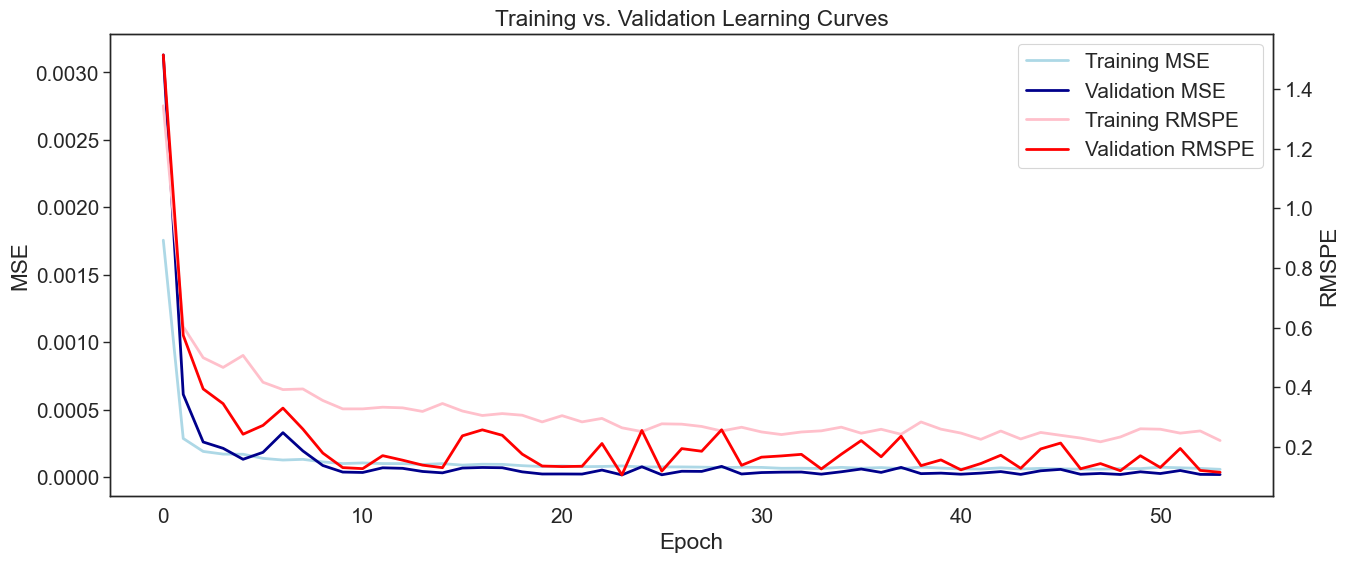

2022-01-24 00:00:00
12/12 [==============================] - 1s 5ms/step


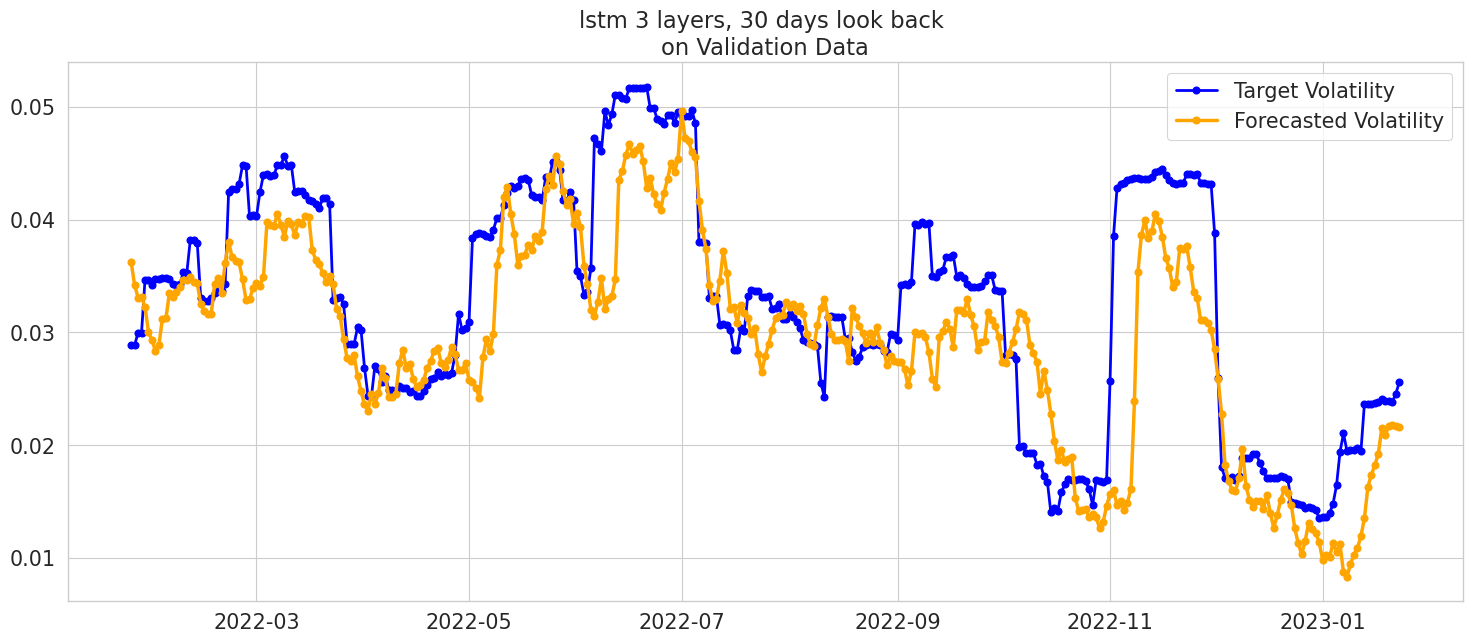

In [129]:
i = 0 # for perf_df

#loop subdatasets
for features in list_feat: 

    input_df = df[features]

    X_train = input_df.loc[train_idx]

    seed=1234

    tf.keras.backend.clear_session()

    # Seed for reproducibility
    np.random.seed(seed)

    n_past = 30
    batch_size = 64
    n_dims = input_df.shape[1]

    mat_X_train, mat_y_train = um.windowed_dataset(X_train, y_train['vol_future'], n_past)

    lstm_3 = tf.keras.models.Sequential([  
        tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
        # normalize,
   
        tf.keras.layers.BatchNormalization(), 
        
        # 3rd LSTM layer
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.1),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Dropout(0.1),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Dense(1)
    ])

    lstm_3.compile(loss='mse', 
                optimizer="adam", 
                metrics=[um.rmspe])

    #saving model
    checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                    save_best_only=True,
                                    monitor='val_rmspe')

    # stopping the training if validation rmspe is not improving    
    early_stopping_cb = EarlyStopping(patience=30,
                                    restore_best_weights=True,
                                    monitor='val_rmspe')


    # fitting training data
    lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train, 
                            callbacks=[checkpoint_cb, early_stopping_cb],
                                validation_split=0.2, shuffle=True,
                            verbose=0, batch_size=batch_size, epochs=200)


    # learning curves
    um.viz_train_val_metrics(lstm_3_res)

    # forecasting on validation set
    lstm_3_preds = um.forecast_multi(lstm_3, val_idx, input_df=input_df, df=df, n_past=n_past)

    # test scaling
    lstm_3_preds_scaled = um.scale(scaler_vol, lstm_3_preds)

    # plotting predictions-target
    um.viz_model(y_val['vol_future'], lstm_3_preds, 
            f"lstm 3 layers, 30 days look back")
    plt.show()


    ## append metrics to perf_df 
    um.log_perf(y_val['vol_future'], lstm_3_preds,
         f"lstm 3 layers {i}", perf_df=perf_df)
    
    i = i+1

In [130]:
# Results
perf_df

Model  Validation RMSPE  Validation RMSE
0          xgboost          0.268343         0.007288
1         catboost          0.292853         0.007015
2  lstm 2 layers 0          0.167645         0.005485
3  lstm 3 layers 0          0.204122         0.006669

### BI-LSTM 4 Layers

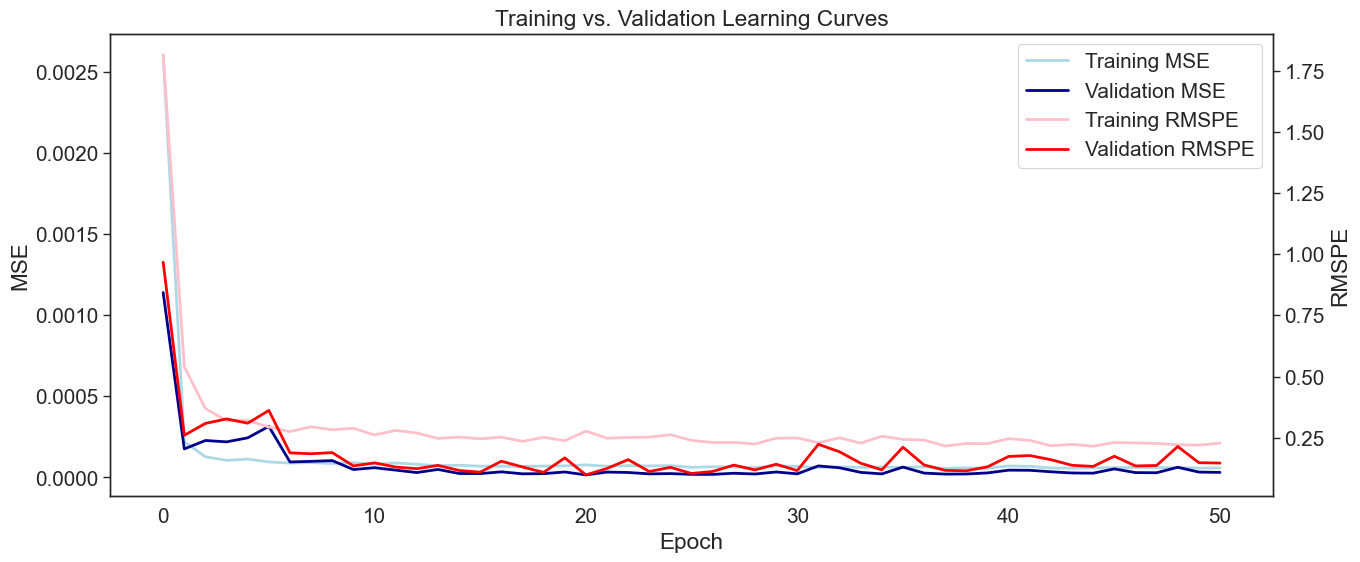

2022-01-24 00:00:00
12/12 [==============================] - 1s 12ms/step


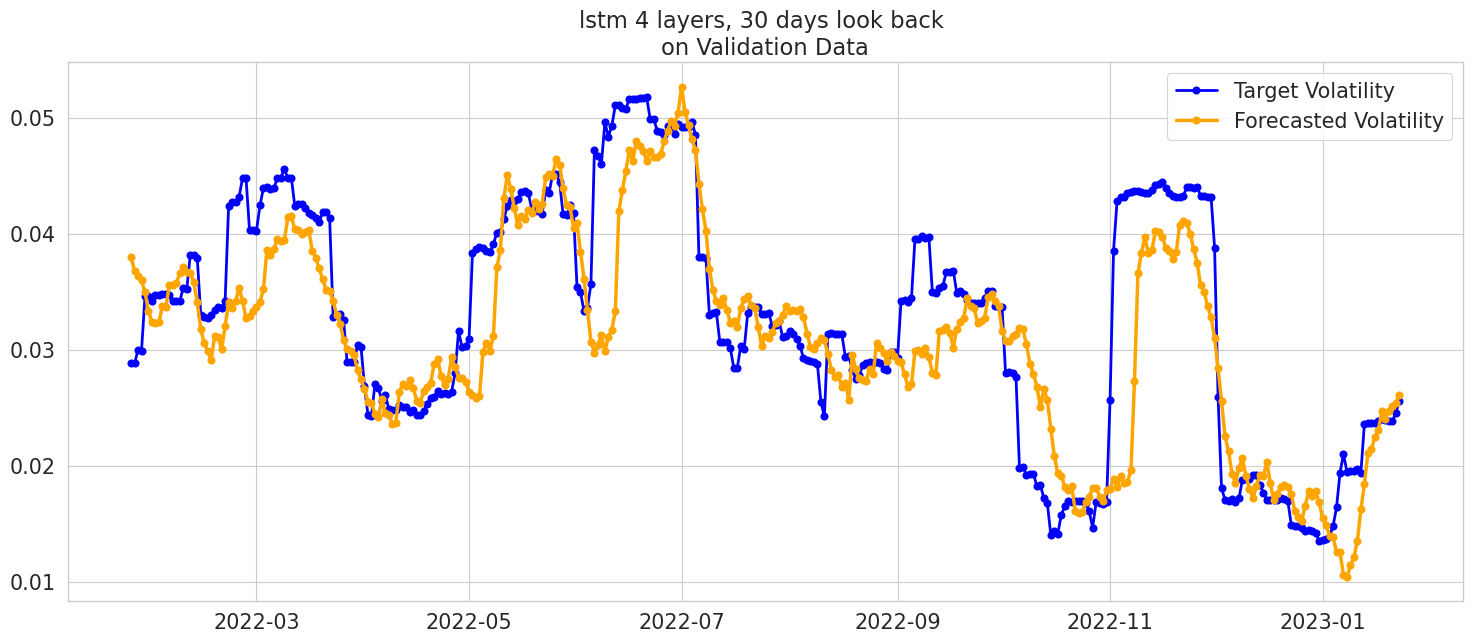

In [131]:
i = 0 # for perf_df

#loop subdatasets
for features in list_feat: 
    
    # SEPARATE INPUT DATAFRAME FROM df
    input_df = df[features]

    # SEPARATE INPUTS FOR TRAINING SET ONLY
    X_train = input_df.loc[train_idx]

    seed=1234

    tf.keras.backend.clear_session()

    # Seed for reproducibility
    np.random.seed(seed)

    n_past = 30
    batch_size = 64
    n_dims = input_df.shape[1]

    mat_X_train, mat_y_train = um.windowed_dataset(X_train, y_train['vol_future'], n_past)


    lstm_4 = tf.keras.models.Sequential([  
        tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
  
        tf.keras.layers.BatchNormalization(), 

        # 4th LSTM layer
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.1),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.1),
 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Dropout(0.1),

        tf.keras.layers.Dense(1)
    ])

    lstm_4.compile(loss='mse', 
                optimizer="adam", 
                metrics=[um.rmspe])

    #saving model
    checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                    save_best_only=True,
                                    monitor='val_rmspe')

    # stopping the training if validation rmspe is not improving    
    early_stopping_cb = EarlyStopping(patience=30,
                                    restore_best_weights=True,
                                    monitor='val_rmspe')



        # fitting training data
    lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, 
                            callbacks=[checkpoint_cb, early_stopping_cb],
                                validation_split=0.2, shuffle=True,
                            verbose=0, batch_size=batch_size, epochs=200)


    # learning curves
    um.viz_train_val_metrics(lstm_4_res)

    # forecasting on validation set
    lstm_4_preds = um.forecast_multi(lstm_4, val_idx, input_df=input_df, df=df, n_past=n_past)

    # test scaling
    lstm_4_preds_scaled = um.scale(scaler_vol, lstm_4_preds)

    # plotting predictions-target
    um.viz_model(y_val['vol_future'], lstm_4_preds, 
            f"lstm 4 layers, 30 days look back")
    plt.show()


    ## append metrics to perf_df 
    um.log_perf(y_val['vol_future'], lstm_4_preds,
         f"lstm 4 layers {i}", perf_df=perf_df)
    
    i = i+1

In [132]:
# Results
perf_df.sort_values('Validation RMSPE').head(20)

Model  Validation RMSPE  Validation RMSE
2  lstm 2 layers 0          0.167645         0.005485
4  lstm 4 layers 0          0.180273         0.005892
3  lstm 3 layers 0          0.204122         0.006669
0          xgboost          0.268343         0.007288
1         catboost          0.292853         0.007015

### Hypertuning BI-LSTM

In [140]:
#from talos import Scan

In [141]:
def lstm_network(X_tr, y_tr, X_v, y_v, params):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]))

    # hidden layers
    for layer in range(params['lstm_layers'],1,-1):
        # FOR THE LAST LAYER - return_sequences NEEDS TO BE False
        # ALL OTHER LAYERS - returns_sequences = True
        seq = False if layer == 1 else True
        
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(2**(layer+3),
                                                                     return_sequences=seq,
                                                                     activation=params['activation'])))
        model.add(tf.keras.layers.Dropout(params['dropout']))

    model.add(tf.keras.layers.Dense(1))

    model.compile(loss='mse', 
                  optimizer='adam', 
                  metrics=[um.rmspe])
    
    # stopping the training if validation rmspe is not improving 
    early_stopping_cb = EarlyStopping(patience=3,
                                      restore_best_weights=True,
                                      monitor='val_rmspe')
    
    res = model.fit(X_tr, y_tr, 
                    validation_data=(X_v, y_v),
                    batch_size=params['batch_size'],
                    epochs=10,
                    verbose=0,
                    callbacks=[early_stopping_cb])
    
    return res, model

In [142]:
params = {'dropout': [0.1, 0.2], 
          'activation': ['relu', 'tanh', 'sigmoid'], 
          'lstm_layers': [2,3,4],
          'batch_size': [32,64]}

In [144]:
tf.keras.backend.clear_session()

seed = 1234
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

# SEPARATE INPUT DATAFRAME FROM df
input_df = df[features_0]

# SEPARATE INPUTS FOR TRAINING SET ONLY
X_train = input_df.loc[train_idx]

n_past = 30
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = um.windowed_dataset(X_train, y_train['vol_future'], n_past)

from_i = val_idx[0] - timedelta(n_past - 1)
to_i = val_idx[-1]
mat_X_val, mat_y_val = um.windowed_dataset(input_df[from_i:to_i], 
                                        df.vol_future[val_idx], n_past)

#results = talos.Scan(x=mat_X_train, y=mat_y_train, 
                     #x_val=mat_X_val, y_val=mat_y_val,
                     #params=params, 
                     #model=lstm_network,
                     #experiment_name='grid',
                     #reduction_metric='rmspe',
                     #minimize_loss=True)

In [146]:
#results.data.sort_values(by='val_rmspe', ascending=True)[:3]

In [147]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)



n_past = 30
batch_size = 32
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_8 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # normalize,
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,
                                                       activation='tanh')),
    tf.keras.layers.Dropout(0.1),

    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='tanh')),
    tf.keras.layers.Dropout(0.1),
    
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_8.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_8.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_8.summary())

NameError: name 'windowed_dataset' is not defined